In [1]:
%cd '/jetfs/home/a12233665/pai-munich-vienna/'
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import LinearNDInterpolator
from datetime import datetime
from joblib import Parallel, delayed
from joblib.externals.loky import set_loky_pickler
set_loky_pickler('pickle')
from numba import njit
import xarray as xr
from pathlib import Path
import gc
import quadprog

from kendapy.ekf import Ekf
from enstools.io import read, write

import pai.observation as oi
from pai.localization import get_dist_from_obs, find_analysis_in_area
import pai.localization as loc
import pai.pai_utils as paiut
import pai.partial_analysis_increment_np as PAI
import pai.plot_oi_utils as utils

import cartopy.crs as ccrs

import cProfile, pstats, io
from pstats import SortKey
import time

from metpy.calc import relative_humidity_from_specific_humidity, mixing_ratio_from_relative_humidity, specific_humidity_from_mixing_ratio
from metpy.units import units

#%pip install statsmodels
import statsmodels.api as sm
import statsmodels.graphics as smg
from scipy import stats

/jetfs/home/a12233665/pai-munich-vienna


/jetfs/home/a12233665/.local/lib/python3.8/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.24.2
  warnings.warn(


In [2]:
def get_local_regions(obslon, obslat, h_loc=25.0):
    #Get region close to the radiosonde and restrict analysis and radiances to this region.
    rot_lons, rot_lats = oi.location_to_rotated_pole([obslon, obslon], [obslat, obslat])

    infl_reg, obs_reg = paiut.get_regions(*rot_lons, *rot_lats, hloc=h_loc)

    infl_reg_latlon = np.array(rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])).flatten()

    return infl_reg_latlon

In [3]:
def rotated_pole_to_location(rlons, rlats):
    #
    rotated_pole = ccrs.RotatedPole(pole_latitude=40, pole_longitude=-170)
    rotated_coords = [
        ccrs.PlateCarree().transform_point(rlon, rlat, rotated_pole)
        for (rlon, rlat) in zip(rlons, rlats)
    ]

    lons, lats = zip(*rotated_coords)

    return np.array(lons), np.array(lats)

In [4]:
def get_local_regions(obslon, obslat, h_loc=25.0):
    #Get region close to the radiosonde and restrict analysis and radiances to this region.
    rot_lons, rot_lats = oi.location_to_rotated_pole([obslon, obslon], [obslat, obslat])

    infl_reg, obs_reg = paiut.get_regions(*rot_lons, *rot_lats, hloc=h_loc)

    infl_reg_latlon = np.array(rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])).flatten()

    return infl_reg_latlon

In [5]:
def pai_loop_over_obs_slow(obs_list, vars, enslon, enslat, ep_values, mean_pres, nens):
    incr = [[vars[i], np.zeros((ep_values[i].shape[1], ep_values[i].shape[2]))] for i in range(len(vars))]
    #ep_values = [ens_perturb[var].values for var in vars]
    for i, obs in enumerate(obs_list):
        hgc = PAI.compute_hloc(obs["obslat"], obs["obslon"], obs["hloc"], enslat, enslon)

        if obs["vloc"] < 10:
            vgc = PAI.compute_vloc(obs["obspres"] / 100.0, obs["vloc"], mean_pres / 100.0)
        else:
            vgc = 1
        kcol = [PAI.compute_kalman_gain(
            obs["anaensT"],
            obs["err"],
            ep_values[k],
            nens,
            hgc=hgc,
            vgc=vgc
        ) for k in range(len(vars))]
        for i in range(len(vars)):
            incr[i][1] += PAI.compute_increment(kcol[i], obs["fgmeandep"])
    return incr

In [6]:
def C_Matrix(PAI_vals, PAI_lats, PAI_lons, ana_plevs,  obs_lat, obs_lon, obs_plevs, input_form = np.array(range(0, 65, 2))):
    #Returns the C matrix for a radiosonde location and specific PAI output.
    #PAI_vals should be a numpy array, the first axis should be horizontal location, equivalent to PAI_lons/lats and the other axis should be pressure levels.
    #Note that we interpolate onto analysis pressure levels - the p variable in the PAI vector is an increment. Could cause issues.
    #obs_lat, obs_lon, and obs_plevs should be the latitude, longitude, and pressure levels of the observation.
    #Example of inputs used in script below: 
    output_form = np.array(range(65))
    interp_h = LinearNDInterpolator(list(zip(PAI_lats, PAI_lons)), PAI_vals)
    interp_p = LinearNDInterpolator(list(zip(PAI_lats, PAI_lons)), ana_plevs)
    PAI_h_interp = interp_h(obs_lat, obs_lon)
    PAI_p_interp = interp_p(obs_lat, obs_lon)
    C_as_list = []
    for i in range(len(PAI_p_interp)):
        model_c = np.zeros(len(PAI_p_interp))
        model_c[i] = PAI_h_interp[i]
        #print(len(model_c), len(obs_plevs))
        #print(obs_plevs.shape, PAI_p_interp.shape, model_c.shape)
        #print(np.interp(obs_plevs, PAI_p_interp[:, 0], model_c))
        C_as_list.append(np.interp(obs_plevs, PAI_p_interp, model_c))
    thinning_interp = []
    for i in range(len(input_form)):
        id_at_point = np.zeros(len(input_form))
        id_at_point[i] = 1
        thinning_interp.append(np.interp(output_form, input_form, id_at_point))
    thinning_interp = np.array(thinning_interp).T
    C_full_length = np.array(C_as_list).T
    return (C_full_length @ thinning_interp).T

In [7]:
def y_equivalent(ana_vals_no_obs, PAI_lats, PAI_lons, ana_plevs,  obs_lat, obs_lon, obs_plevs):
    #Returns the observation equivalent vector for a radiosonde location and analysis with observation removed by PAI. Will go into the dy error term.
    #PAI_vals should be a numpy array, the first axis should be horizontal location, equivalent to PAI_lons/lats and the other axis should be pressure levels.
    #Note that we interpolate onto analysis pressure levels - the p variable in the PAI vector is an increment. Could cause issues.
    #obs_lat, obs_lon, and obs_plevs should be the latitude, longitude, and pressure levels of the observation.
    #Example of inputs used in script below:
    interp_h = LinearNDInterpolator(list(zip(PAI_lats, PAI_lons)), ana_vals_no_obs)
    interp_p = LinearNDInterpolator(list(zip(PAI_lats, PAI_lons)), ana_plevs)
    PAI_h_interp = interp_h(obs_lat, obs_lon)
    PAI_p_interp = interp_p(obs_lat, obs_lon)
    y = np.interp(obs_plevs, PAI_p_interp, PAI_h_interp)
    return y

In [8]:
def ELF_plot2(save_name_list, save_date, Weights = True, constant = True, vble = 'T',): #otherwise 'RH'
    input_form = np.array(range(0, 65, 3))
    if vble == 'T':
        e_o_name = '_e_o_Ts_'
        y_name = '_y_Ts_'
        C_name = '_C_Ts_'
        incr_name = '_incrs_'
        mean_name = '_means_T_'
    else:
        e_o_name = '_e_o_Qs_'
        y_name = '_y_Qs_'
        C_name = '_C_Qs_'
        incr_name = '_incrs_Q_'
        mean_name = '_means_Q_'
    for i, save_name in enumerate(save_name_list):
        if i == 0:
            e_o_list = np.load(save_name + e_o_name + save_date + '.npy')
            y = np.load(save_name + y_name + save_date + '.npy')
            X = np.load(save_name + C_name + save_date + '.npy').T
            incrs = np.load(save_name + incr_name + save_date + '.npy')
            means = np.load(save_name + mean_name + save_date + '.npy')
            print(e_o_list.shape, y.shape, X.shape, incrs.shape, means.shape)
        else:
            e_o_list = np.concatenate([e_o_list, np.load(save_name + e_o_name + save_date + '.npy')])
            y = np.concatenate([y, np.load(save_name + y_name + save_date + '.npy')])
            X = np.concatenate([X, np.load(save_name + C_name + save_date + '.npy').T])
            incrs = np.concatenate([incrs, np.load(save_name + incr_name + save_date + '.npy')])
            means = np.concatenate([means, np.load(save_name + mean_name + save_date + '.npy')])
            print(e_o_list.shape, y.shape, X.shape, incrs.shape, means.shape)
    if Weights:
        W = 1/(np.array(e_o_list)**2)
    else:
        W = np.ones(len(y))
    
    non_zero_indices = np.where((X != 0).any(axis=0))[0]
    X_non_zero = X[:,  non_zero_indices]
    X_with_const = np.concatenate([X_non_zero, np.ones((X_non_zero.shape[0], 1))], axis = 1)
    print(y.shape, X_non_zero.shape, W.shape, X_with_const.shape)
    print(y.shape, X.shape, W.shape)
    if constant == True:
        mod_wls = sm.WLS(y, X_with_const, weights = W, hasconst=True)
    else:
        mod_wls = sm.WLS(y, X_non_zero, weights = W, hasconst=False)
    res_wls = mod_wls.fit()
    print(np.linalg.solve(np.matmul(np.matmul(X_with_const.T, np.diag(W)), X_with_const), np.matmul(X_with_const.T, np.matmul(np.diag(W), y))))
    #np.matmul(X_with_const, ))
    print(res_wls.summary())
    if constant == True:
        P = np.matmul(X_with_const.T, np.matmul(np.diag(W), X_with_const))
        print(P.shape, X_with_const.shape, W.shape)
        q = np.matmul(X_with_const.T, np.matmul(np.diag(W), y))
        print(q.shape)
    else:
        P = np.matmul(X_non_zero.T, np.matmul(np.diag(W), X_non_zero))
        print(P.shape, X_non_zero.shape, W.shape)
        q = np.matmul(X_non_zero.T, np.matmul(np.diag(W), y))
        print(q.shape)
    if constant == True:
        G = np.concatenate([np.eye(q.shape[0] - 1), -np.eye(q.shape[0] - 1)], axis = 1)
        G = np.concatenate([G, np.zeros((1, G.shape[1]))], axis = 0)
        h = np.concatenate([np.zeros(q.shape[0] - 1), -np.ones(q.shape[0] - 1)], axis = 0)
        
    else:
        G = np.concatenate([np.eye(q.shape[0]), -np.eye(q.shape[0])], axis = 1)
        h = np.concatenate([np.zeros(q.shape[0]), -np.ones(q.shape[0])], axis = 0)
    meq = 0
    print(G.shape, h.shape)
    
    soln = quadprog.solve_qp(P, q, G, h, meq)
    print(soln[0])
    ana_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2/20230601120000/an_R19B07.20230601120000.mean'
    mean = paiut.read_grib(ana_path, 't')
    ana_p_interp = mean.pres.isel(time=0).mean(dim = 'cell') 
    %matplotlib inline
    fig, axs = plt.subplots(1, 5, figsize = (15, 10))
    fig.tight_layout()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    if vble == 'T':
        print(res_wls.conf_int(alpha = 0.5))
        if constant == True:
            coeffs = res_wls.params[:-1]
            conf_int_lower = np.array(res_wls.conf_int(alpha = 0.05))[:-1, 0]
            conf_int_upper = np.array(res_wls.conf_int(alpha = 0.05))[:-1, 1]
        else:  
            coeffs = res_wls.params
            conf_int_lower = np.array(res_wls.conf_int(alpha = 0.05))[:, 0]
            conf_int_upper = np.array(res_wls.conf_int(alpha = 0.05))[:, 1]
        verts = ana_p_interp[input_form][non_zero_indices] / 100
        print(conf_int_lower, conf_int_upper)
    else:
        if constant == True:
            coeffs = res_wls.params[:-1]#[5:-1]
        else:  
            coeffs = res_wls.params#[5:]
        verts = ana_p_interp[input_form][non_zero_indices] / 100 #[5:]
    axs[0].plot(coeffs[1:], verts[1:])
    axs[0].fill_betweenx(verts[1:], conf_int_lower[1:], conf_int_upper[1:], alpha = 0.3)
    axs[0].axvline(x = 0, color = 'black', alpha = 0.4)
    axs[0].invert_yaxis()
    if constant == True:
        axs[0].text(0.05, 0.95, f'Constant = {res_wls.params[-1]:.2f}', 
                    transform=axs[0].transAxes, 
                    fontsize=14,verticalalignment='top', 
                    bbox=props)
    if vble == 'T':
        axs[0].set_title('(1) Weighted regression for Error to T, K', fontsize = 14)
    else:
        axs[0].set_title('(1) Weighted regression for Error to q', fontsize = 14)
    axs[0].set_ylabel('Pressure (hPa)', fontsize = 14)
    axs[0].set_xlabel('ELF', fontsize = 14)

    rho_len = len(coeffs)
    WLS_in_bounds = np.maximum(np.zeros(rho_len), np.minimum(coeffs, np.ones(rho_len)))
    axs[1].plot(WLS_in_bounds[1:], verts[1:])
    axs[1].invert_yaxis()
    if constant == True:
        axs[1].text(0.05, 0.95, f'Constant = {res_wls.params[-1]:.2f}', 
                    transform=axs[1].transAxes, 
                    fontsize=14,verticalalignment='top', 
                    bbox=props)
    axs[1].set_title('(2) as (1) but projected to bounds', fontsize = 14)

    
    if constant == True:
        axs[2].plot(soln[0][:-1], ana_p_interp[input_form][non_zero_indices] / 100)
        axs[2].text(0.05, 0.95, f'Constant = {soln[0][-1]:.2f}', 
                    transform=axs[2].transAxes, 
                    fontsize=14,verticalalignment='top', 
                    bbox=props)
    else:
        axs[2].plot(soln[0][1:], ana_p_interp[input_form][non_zero_indices][1:] / 100)
    axs[2].invert_yaxis()
    if vble == 'T':
        axs[2].set_title('(3) Quadratic Programming, error to T in K', fontsize = 14)
    else:
        axs[2].set_title('(3) Quadratic Programming, error to Q in kg/kg', fontsize = 14)
    
    #axs[3].plot(np.mean(incrs, axis = 0), ana_p_interp/100)#axs[3].plot(np.mean(means_T - incrs_T, axis = 0), ana_p_interp/100)
    #axs[3].plot(np.mean(means, axis = 0), ana_p_interp/100)
    axs[3].plot(np.std(incrs, axis = 0), ana_p_interp/100)#axs[3].plot(np.mean(means_T - incrs_T, axis = 0), ana_p_interp/100)
    if vble == 'T':
        axs[3].set_xlabel('Temperature (K)', fontsize = 14)
        axs[3].set_title('Standard Deviation of Increments, K', fontsize = 14)
    else:
        axs[3].set_xlabel('Specific Humidity (kg/kg))', fontsize = 14)
        axs[3].set_title('Standard Deviation of Increments, kg/kg', fontsize = 14)
    axs[3].invert_yaxis()

    #cls = Linear_Reg_Diagnostic(res_wls)

    fig, axs = plt.subplots(1, 3, figsize = (20, 10))
    sns.residplot(
            x=res_wls.fittedvalues,
            y=res_wls.resid,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=axs[0])
    influence = mod_wls.RegressionResults.get_influence()
    residual_norm = influence.resid_studentized_internal
    leverage = influence.hat_matrix_diag
    sns.regplot(
            x=leverage,
            y=residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=axs[1])
    
    #smg.gofplots.qqplot(res_wls.resid, line = '45', ax = axs[4])
    #axs[4].hist(res_wls.resid, bins = 30)
    if constant:
        fig.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/ELF_With_Const' + vble + '.png', bbox_inches='tight')
    else:
        fig.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/ELF_No_Const' + vble + '.png', bbox_inches='tight')

In [9]:
def ELF_plot_split(save_name_list, save_date, Weights = True, constant = True, vble = 'T', input_form = np.array(range(0, 65, 3)), above_threshold_name = 'Cloudy', below_threshold_name = 'Clear', threshold = 0.4, cloudvar = 'VIS', save = True, plot_save_name = '', Channel = 'Visible', list_choice = 'old', plot_GC = False, GC_params = ['multi_peak', 35000, 0.5, 87000, 0.1], GC_params_above = ['multi_peak', 33000, 0.4,  90000, 0.07 ], GC_params_below = ['single_peak', 35000, 1, 35000, 1], draw_legend = True): #otherwise 'RH, '
    if plot_GC:
        plot_multi_peak = [GC_params[0] == 'multi_peak', GC_params_above[0] == 'multi_peak', GC_params_below[0] == 'multi_peak']
        GC_plevs1 = [GC_params[1], GC_params_above[1], GC_params_below[1]]
        GC_plevs2 = [GC_params[3], GC_params_above[3], GC_params_below[3]]
        GC_widths1 = [GC_params[2], GC_params_above[2], GC_params_below[2]]
        GC_widths2 = [GC_params[4], GC_params_above[4], GC_params_below[4]]
    if vble == 'T':
        e_o_name = '_e_o_Ts_'
        y_name = '_y_Ts_'
        C_name = '_C_Ts_'
        incr_name = '_incrs_'
        mean_name = '_means_T_'
        if cloudvar == 'VIS':
            cloud_name = '_VIS_T_'
        elif cloudvar == 'IR0':
            cloud_name = '_IR1_T_'
        elif cloudvar == 'IR1':
            cloud_name = '_IR2_T_'
    else:
        e_o_name = '_e_o_Qs_'
        y_name = '_y_Qs_'
        C_name = '_C_Qs_'
        incr_name = '_incrs_Q_'
        mean_name = '_means_Q_'
        if cloudvar == 'VIS':
            cloud_name = '_VIS_Q_'
        elif cloudvar == 'IR0':
            cloud_name = '_IR1_Q_'
        elif cloudvar == 'IR1':
            cloud_name = '_IR2_Q_'
    for i, save_name in enumerate(save_name_list):
        if list_choice == 'old':
            list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_01_11',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_11_21',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_21_31'][i]
        elif list_choice == '6am':
            list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_6_ELF_01_11',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_6_ELF_11_21',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_6_ELF_21_31'][i]
        elif list_choice == 'midnight':
            list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_midnight_ELF_01_11',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_midnight_ELF_11_21',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_midnight_ELF_21_31'][i]
            print('midnight')
        elif list_choice == 'full_VIS':
            list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_VIS_ELF_01_11',
                              '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_VIS_ELF_11_21',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_VIS_ELF_21_31'][i] 
        else:
            list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_01_11',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_11_21',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_21_31'][i]
        if i == 0:
            e_o_list = np.load(list_save_name + e_o_name + save_date + '.npy')
            cloud_list = np.load(list_save_name + cloud_name + save_date + '.npy')
            y = np.load(save_name + y_name + save_date + '.npy')
            X = np.load(save_name + C_name + save_date + '.npy').T
            incrs = np.load(save_name + incr_name + save_date + '.npy')
            means = np.load(save_name + mean_name + save_date + '.npy')
            print(e_o_list.shape, y.shape, X.shape, incrs.shape, means.shape)
        else:
            e_o_list = np.concatenate([e_o_list, np.load(list_save_name + e_o_name + save_date + '.npy')])
            cloud_list = np.concatenate([cloud_list, np.load(list_save_name + cloud_name + save_date + '.npy')])
            y = np.concatenate([y, np.load(save_name + y_name + save_date + '.npy')])
            X = np.concatenate([X, np.load(save_name + C_name + save_date + '.npy').T])
            incrs = np.concatenate([incrs, np.load(save_name + incr_name + save_date + '.npy')])
            means = np.concatenate([means, np.load(save_name + mean_name + save_date + '.npy')])
            print(e_o_list.shape, y.shape, X.shape, incrs.shape, means.shape)
    
    
    non_zero_indices = np.where((X != 0).any(axis=0))[0]
    X_non_zero = X[:,  non_zero_indices]
    X_above_threshold = X_non_zero[cloud_list > threshold, :]
    X_below_threshold = X_non_zero[cloud_list <= threshold, :]
    y_above_threshold = y[cloud_list > threshold]
    print('Number ' + above_threshold_name + ' = ', len(y_above_threshold))
    y_below_threshold = y[cloud_list <= threshold]
    print('Number ' + below_threshold_name + ' = ', len(y_below_threshold))
    if Weights:
        W = 1/(np.array(e_o_list)**2)
    else:
        W = np.ones(len(y))
    W_above_threshold = W[cloud_list > threshold]
    W_below_threshold = W[cloud_list <= threshold]
    print(X_below_threshold.shape, X_above_threshold.shape,
          y_below_threshold.shape, y_above_threshold.shape)
    mod_wls = sm.WLS(y, X_non_zero, weights = W, hasconst=False)
    mod_wls_above_threshold = sm.WLS(y_above_threshold, X_above_threshold, weights = W_above_threshold, hasconst=False)
    mod_wls_below_threshold = sm.WLS(y_below_threshold, X_below_threshold, weights = W_below_threshold, hasconst=False)
    res_wls = mod_wls.fit()
    res_wls_above_threshold = mod_wls_above_threshold.fit()
    res_wls_below_threshold = mod_wls_below_threshold.fit()
    #print(np.linalg.solve(np.matmul(np.matmul(X_with_const.T, np.diag(W)), X_with_const), np.matmul(X_with_const.T, np.matmul(np.diag(W), y))))
    #np.matmul(X_with_const, ))
    print(res_wls.summary())
    print(res_wls_above_threshold.summary())
    print(res_wls_below_threshold.summary())
    
    P = np.matmul(X_non_zero.T, np.matmul(np.diag(W), X_non_zero))
    print(P.shape, X_non_zero.shape, W.shape)
    q = np.matmul(X_non_zero.T, np.matmul(np.diag(W), y))
    print(q.shape)
    G = np.concatenate([np.eye(q.shape[0]), -np.eye(q.shape[0])], axis = 1)
    h = np.concatenate([np.zeros(q.shape[0]), -np.ones(q.shape[0])], axis = 0)
    meq = 0
    print(G.shape, h.shape)
    
    soln = quadprog.solve_qp(P, q, G, h, meq)

    
    ana_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2/20230601120000/an_R19B07.20230601120000.mean'
    mean = paiut.read_grib(ana_path, 't')
    ana_p_interp = mean.pres.isel(time=0).mean(dim = 'cell').values
    #%matplotlib inline
    #fig.tight_layout(w_pad = 6)
    #props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    if vble == 'T':
        print(res_wls.conf_int(alpha = 0.5))
        coeffs = res_wls.params
        conf_int_lower = np.array(res_wls.conf_int(alpha = 0.05))[:, 0]
        conf_int_upper = np.array(res_wls.conf_int(alpha = 0.05))[:, 1]
        verts = ana_p_interp[input_form][non_zero_indices] / 100
        print(verts, (ana_p_interp / 100))
        print(conf_int_lower, conf_int_upper)
    else:
        if constant == True:
            coeffs = res_wls.params[:-1]#[5:-1]
        else:  
            coeffs = res_wls.params#[5:]
        verts = ana_p_interp[input_form][non_zero_indices] / 100 #[5:]

    rho_len = len(coeffs)
    WLS_in_bounds = np.maximum(np.zeros(rho_len), np.minimum(coeffs, np.ones(rho_len)))
    label_size = 19
    fig, ax = plt.subplots(figsize = (5, 10))
    ax.plot(soln[0][1:], ana_p_interp[input_form][non_zero_indices][1:] / 100)
    ax.invert_yaxis()
    for i, WLS in enumerate([res_wls, res_wls_above_threshold, res_wls_below_threshold]):
        coeffs = WLS.params
        conf_int_lower = np.array(WLS.conf_int(alpha = 0.05))[:, 0]
        conf_int_upper = np.array(WLS.conf_int(alpha = 0.05))[:, 1]
        verts = ana_p_interp[input_form][non_zero_indices] / 100
        rho_len = len(coeffs)
        WLS_in_bounds = np.maximum(np.zeros(rho_len), np.minimum(coeffs, np.ones(rho_len)))
        print(['full: ', 'above: ', 'below: '][i], 'Threshold: ', threshold)
        print(coeffs.tolist(), sep=', ')
        print(WLS_in_bounds.tolist(), sep=', ')
        fig, ax = plt.subplots(figsize = (5, 10))
        ax.plot(coeffs, input_form[non_zero_indices])# verts[1:])
        ax.fill_betweenx(input_form[non_zero_indices], conf_int_lower, conf_int_upper, alpha = 0.3) #verts[1:]
        ax.axvline(x = 0, color = 'black', alpha = 0.4)
        ax.axvline(x = 1, color = 'black', alpha = 0.2, linestyle = '--')
        ax.invert_yaxis()
        ax.set_xlim([-3, 3])
        def coords_to_verts(x):
            return np.interp(x, input_form[non_zero_indices], verts)
        def verts_to_coords(y):
            return np.interp(y, verts, input_form[non_zero_indices])
        secax_y = ax.secondary_yaxis(
            'right', functions=(coords_to_verts, verts_to_coords))
        secax_y.tick_params(labelsize = label_size)
        if i == 0:
            ax.set_ylabel('Vertical level', fontsize = label_size)
        if i == 2:
            secax_y.set_ylabel('Average pressure in analysis for interpretation', fontsize = label_size)
        if vble == 'T':
            ax.set_title('Weighted regression for Error to T, \n ' + Channel + ' channel, ' + ['full sample', above_threshold_name, below_threshold_name][i], fontsize = label_size + 1)
        ax.set_xlabel('ELF', fontsize = label_size)
        ax.tick_params(labelsize = label_size)
        if save:
            fig.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/' + plot_save_name + '_ELF_' + ['Full', above_threshold_name, below_threshold_name][i] + '.jpg', bbox_inches='tight')

        if plot_GC:
            GC_plev1 = GC_plevs1[i]
            GC_plev2 = GC_plevs2[i]
            GC_width1 = GC_widths1[i]
            GC_width2 = GC_widths2[i]
            if plot_multi_peak[i]:
                print(type(GC_plev2), type(GC_width2), type(ana_p_interp))
                surface_vgc = PAI.compute_vloc(GC_plev2 / 100, GC_width2, ana_p_interp / 100.0)
                atmos_vgc = PAI.compute_vloc(GC_plev1 / 100.0, GC_width1, ana_p_interp / 100.0)
                surface_influence_atmos = PAI.compute_vloc(GC_plev2 / 100, GC_width2, np.array([GC_plev1]) / 100.0)
                atmos_influence_surface = PAI.compute_vloc(GC_plev1 / 100.0, GC_width1, np.array([GC_plev2]) / 100)
                c_surface = (1 - atmos_influence_surface)/(1 - (atmos_influence_surface * surface_influence_atmos))
                c_atmos = (1 - surface_influence_atmos)/(1 - (atmos_influence_surface * surface_influence_atmos))
                vgc = (c_atmos * atmos_vgc) + (c_surface * surface_vgc)
            else:
                vgc = PAI.compute_vloc(GC_plev1 / 100.0, GC_width1, ana_p_interp / 100.0)
        if draw_legend:
            fig, ax = plt.subplots(figsize = (5, 9))
        else:
            fig, ax = plt.subplots(figsize = (5, 10))
        ax.plot(WLS_in_bounds, input_form[non_zero_indices], label = 'ELF projected to bounds')
        if plot_GC:
            ax.plot(vgc, np.array(range(65)), color = 'r', linestyle = '--', label = 'Normalised sum of two \nGCs fitted to ELF')
        ax.invert_yaxis()
        ax.set_title('Weighted regression projected to bounds, \n ' + Channel + ' channel, ' + ['full sample', above_threshold_name, below_threshold_name][i], fontsize = label_size + 1)
        #ax.set_yticks([])
        secax_y = ax.secondary_yaxis(
            'right', functions=(coords_to_verts, verts_to_coords))
        secax_y.tick_params(labelsize = label_size)
        if i == 0:
            ax.set_ylabel('Vertical level', fontsize = label_size)
        if i == 2:
            secax_y.set_ylabel('Average pressure in analysis on day 1 for interpretation', fontsize = label_size)
        #secax_y.set_ylabel('Average pressure in analysis on day 1 for interpretation', fontsize = label_size)
        ax.set_xlabel('ELF projected to bounds', fontsize = label_size)
        if plot_GC and draw_legend:
            ax.legend(loc = 'upper center', bbox_to_anchor=(0.6, -0.1),shadow=True, ncol=1,fontsize = label_size)
        ax.set_xlim([-0.1, 1.1])
        ax.tick_params(labelsize = label_size)
        if save:
            fig.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/' + plot_save_name + '_ELF_' + ['Full', above_threshold_name, below_threshold_name][i] + '_in_bounds.jpg', bbox_inches='tight')
        


In [47]:
def ELF_plot_compare(save_name_lists, save_date, Weights = True, constant = True, vble = 'T', input_form = np.array(range(0, 65, 3)), above_threshold_name = 'Cloudy', below_threshold_name = 'Clear', threshold = 0.4, cloudvar = 'VIS', save = True, plot_save_name = '', Channel = 'Visible', list_choices = ['old', 'old', 'old'], plot_GC = False, GC_params1 = ['multi_peak', 35000, 0.5, 87000, 0.1], GC_params2 = ['multi_peak', 33000, 0.4,  90000, 0.07 ], GC_params3 = ['single_peak', 35000, 1, 35000, 1], draw_legend = True, over_title = 'Raw ELF coefficients', x_lab = 'Raw optimal localisation coefficients'): #otherwise 'RH, '
    if plot_GC:
        plot_multi_peak = [GC_params1[0] == 'multi_peak', GC_params2[0] == 'multi_peak', GC_params3[0] == 'multi_peak']
        GC_plevs1 = [GC_params1[1], GC_params2[1], GC_params3[1]]
        GC_plevs2 = [GC_params1[3], GC_params2[3], GC_params3[3]]
        GC_widths1 = [GC_params1[2], GC_params2[2], GC_params3[2]]
        GC_widths2 = [GC_params1[4], GC_params2[4], GC_params3[4]]
    if vble == 'T':
        e_o_name = '_e_o_Ts_'
        y_name = '_y_Ts_'
        C_name = '_C_Ts_'
        incr_name = '_incrs_'
        mean_name = '_means_T_'
        if cloudvar == 'VIS':
            cloud_name = '_VIS_T_'
        elif cloudvar == 'IR0':
            cloud_name = '_IR1_T_'
        elif cloudvar == 'IR1':
            cloud_name = '_IR2_T_'
    else:
        e_o_name = '_e_o_Qs_'
        y_name = '_y_Qs_'
        C_name = '_C_Qs_'
        incr_name = '_incrs_Q_'
        mean_name = '_means_Q_'
        if cloudvar == 'VIS':
            cloud_name = '_VIS_Q_'
        elif cloudvar == 'IR0':
            cloud_name = '_IR1_Q_'
        elif cloudvar == 'IR1':
            cloud_name = '_IR2_Q_'
    fig, axs = plt.subplots(1, 3, figsize = (19, 10))
    for channel_num, save_name_list in enumerate(save_name_lists):
        list_choice = list_choices[channel_num]
        for i, save_name in enumerate(save_name_list):
            if list_choice == 'old':
                list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_21_31'][i]
            elif list_choice == '6am':
                list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_6_ELF_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_6_ELF_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_6_ELF_21_31'][i]
            elif list_choice == 'midnight':
                list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_midnight_ELF_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_midnight_ELF_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_midnight_ELF_21_31'][i]
                print('midnight')
            elif list_choice == 'full_VIS':
                list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_VIS_ELF_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_VIS_ELF_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_VIS_ELF_21_31'][i] 
            else:
                list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_21_31'][i]
            if i == 0:
                e_o_list = np.load(list_save_name + e_o_name + save_date + '.npy')
                cloud_list = np.load(list_save_name + cloud_name + save_date + '.npy')
                y = np.load(save_name + y_name + save_date + '.npy')
                X = np.load(save_name + C_name + save_date + '.npy').T
                incrs = np.load(save_name + incr_name + save_date + '.npy')
                means = np.load(save_name + mean_name + save_date + '.npy')
                print(e_o_list.shape, y.shape, X.shape, incrs.shape, means.shape)
            else:
                e_o_list = np.concatenate([e_o_list, np.load(list_save_name + e_o_name + save_date + '.npy')])
                cloud_list = np.concatenate([cloud_list, np.load(list_save_name + cloud_name + save_date + '.npy')])
                y = np.concatenate([y, np.load(save_name + y_name + save_date + '.npy')])
                X = np.concatenate([X, np.load(save_name + C_name + save_date + '.npy').T])
                incrs = np.concatenate([incrs, np.load(save_name + incr_name + save_date + '.npy')])
                means = np.concatenate([means, np.load(save_name + mean_name + save_date + '.npy')])
                print(e_o_list.shape, y.shape, X.shape, incrs.shape, means.shape)
        
    
        non_zero_indices = np.where((X != 0).any(axis=0))[0]
        X_non_zero = X[:,  non_zero_indices]
        if Weights:
            W = 1/(np.array(e_o_list)**2)
        else:
            W = np.ones(len(y))
        mod_wls = sm.WLS(y, X_non_zero, weights = W, hasconst=False)
        res_wls = mod_wls.fit()
        print(res_wls.summary())

        ana_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2/20230601120000/an_R19B07.20230601120000.mean'
        mean = paiut.read_grib(ana_path, 't')
        ana_p_interp = mean.pres.isel(time=0).mean(dim = 'cell').values
        #%matplotlib inline
        #fig.tight_layout(w_pad = 6)
        #props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        label_size = 26
        coeffs = res_wls.params
        conf_int_lower = np.array(res_wls.conf_int(alpha = 0.05))[:, 0]
        conf_int_upper = np.array(res_wls.conf_int(alpha = 0.05))[:, 1]
        verts = ana_p_interp[input_form][non_zero_indices] / 100
        rho_len = len(coeffs)
        WLS_in_bounds = np.maximum(np.zeros(rho_len), np.minimum(coeffs, np.ones(rho_len)))
        print(['full: ', 'above: ', 'below: '][i], 'Threshold: ', threshold)
        print(coeffs.tolist(), sep=', ')
        print(WLS_in_bounds.tolist(), sep=', ')
        if plot_GC == False:
            axs[channel_num].plot(coeffs, input_form[non_zero_indices])# verts[1:])
            axs[channel_num].fill_betweenx(input_form[non_zero_indices], conf_int_lower, conf_int_upper, alpha = 0.3) #verts[1:]
            axs[channel_num].axvline(x = 0, color = 'black', alpha = 0.4)
            axs[channel_num].axvline(x = 1, color = 'black', alpha = 0.2, linestyle = '--')
            axs[channel_num].invert_yaxis()
            axs[channel_num].set_xlim([-3, 3])
            def coords_to_verts(x):
                return np.interp(x, input_form[non_zero_indices], verts)
            def verts_to_coords(y):
                return np.interp(y, verts, input_form[non_zero_indices])
            if channel_num == 2:
                secax_y = axs[channel_num].secondary_yaxis(
                    'right', functions=(coords_to_verts, verts_to_coords))
                secax_y.tick_params(labelsize = label_size)
                secax_y.set_ylabel('Average pressure in analysis (for interpretation)', fontsize = label_size)
            if channel_num == 0:
                axs[channel_num].set_ylabel('Vertical level', fontsize = label_size)
                axs[channel_num].tick_params(labelsize = label_size)
            else:
                axs[channel_num].tick_params(left = False, labelleft = False, labelsize = label_size)
            if vble == 'T':
                axs[channel_num].set_title(['VIS 0.6', 'IR 6.2', 'IR 7.3'][channel_num], fontsize = label_size + 1)
            #axs[channel_num].set_xlabel('ELF', fontsize = label_size)
        
        
        else:
            GC_plev1 = GC_plevs1[channel_num]
            GC_plev2 = GC_plevs2[channel_num]
            GC_width1 = GC_widths1[channel_num]
            GC_width2 = GC_widths2[channel_num]
            if plot_multi_peak[channel_num]:
                print(type(GC_plev2), type(GC_width2), type(ana_p_interp))
                surface_vgc = PAI.compute_vloc(GC_plev2 / 100, GC_width2, ana_p_interp / 100.0)
                atmos_vgc = PAI.compute_vloc(GC_plev1 / 100.0, GC_width1, ana_p_interp / 100.0)
                surface_influence_atmos = PAI.compute_vloc(GC_plev2 / 100, GC_width2, np.array([GC_plev1]) / 100.0)
                atmos_influence_surface = PAI.compute_vloc(GC_plev1 / 100.0, GC_width1, np.array([GC_plev2]) / 100)
                c_surface = (1 - atmos_influence_surface)/(1 - (atmos_influence_surface * surface_influence_atmos))
                c_atmos = (1 - surface_influence_atmos)/(1 - (atmos_influence_surface * surface_influence_atmos))
                vgc = (c_atmos * atmos_vgc) + (c_surface * surface_vgc)
            else:
                vgc = PAI.compute_vloc(GC_plev1 / 100.0, GC_width1, ana_p_interp / 100.0)
            axs[channel_num].plot(WLS_in_bounds, input_form[non_zero_indices], label = 'ELF projected to bounds')
            axs[channel_num].plot(vgc, np.array(range(65)), color = 'r', linestyle = '--', label = 'Normalised sum of two \nGCs fitted to ELF')
            axs[channel_num].invert_yaxis()
            axs[channel_num].set_title(['VIS 0.6', 'IR 6.2', 'IR 7.3'][channel_num], fontsize = label_size + 1)
            #axs[channel_num].set_yticks([])
            def coords_to_verts(x):
                return np.interp(x, input_form[non_zero_indices], verts)
            def verts_to_coords(y):
                return np.interp(y, verts, input_form[non_zero_indices])
            if channel_num == 2:
                secax_y = axs[channel_num].secondary_yaxis(
                    'right', functions=(coords_to_verts, verts_to_coords))
                secax_y.tick_params(labelsize = label_size)
                secax_y.set_ylabel('Average pressure in analysis on day 1 for interpretation', fontsize = label_size)
            if channel_num == 0:
                axs[channel_num].set_ylabel('Vertical level', fontsize = label_size)
                axs[channel_num].tick_params(labelsize = label_size)
            else:
                axs[channel_num].tick_params(left = False, labelleft = False, labelsize = label_size)
            #ax.set_xlabel('ELF projected to bounds', fontsize = label_size)
            if plot_GC and draw_legend and channel_num == 1:
                axs[channel_num].legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.1),shadow=True, ncol=1,fontsize = label_size)
            axs[channel_num].set_xlim([-0.1, 1.1])
            
    fig.suptitle(over_title, fontsize = label_size + 2)
    fig.text(0.5, 0.04, x_lab, ha='center', fontsize = label_size + 1)
    if save:
        fig.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/' + plot_save_name + '.jpg', bbox_inches='tight')
    


In [10]:
def ELF_plot_cloud_on_off(save_name_list, save_date, Weights = True, constant = True, vble = 'T', input_form = np.array(range(0, 65, 3)), above_threshold_name = 'Cloudy', below_threshold_name = 'Clear', threshold = 0.4, cloudvar = 'VIS', save = True, plot_save_name = '', list_choice = 'old'): #otherwise 'RH'
    if vble == 'T':
        e_o_name = '_e_o_Ts_'
        y_name = '_y_Ts_'
        C_name = '_C_Ts_'
        incr_name = '_incrs_'
        mean_name = '_means_T_'
        if cloudvar == 'VIS':
            cloud_name = '_VIS_T_'
        elif cloudvar == 'IR0':
            cloud_name = '_IR1_T_'
        elif cloudvar == 'IR1':
            cloud_name = '_IR2_T_'
    else:
        e_o_name = '_e_o_Qs_'
        y_name = '_y_Qs_'
        C_name = '_C_Qs_'
        incr_name = '_incrs_Q_'
        mean_name = '_means_Q_'
        if cloudvar == 'VIS':
            cloud_name = '_VIS_Q_'
        elif cloudvar == 'IR0':
            cloud_name = '_IR1_Q_'
        elif cloudvar == 'IR1':
            cloud_name = '_IR2_Q_'
    for i, save_name in enumerate(save_name_list):
        if list_choice == 'old':
            list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_01_11',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_11_21',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_21_31'][i]
        elif list_choice == '6am':
            list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_6_ELF_01_11',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_6_ELF_11_21',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_6_ELF_21_31'][i]
        elif list_choice == 'IR1':
            list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5IR1ELF_01_11',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5IR1ELF_11_21',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5IR1ELF_21_31'][i]
        elif list_choice == 'midnight':
            list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_midnight_ELF_01_11',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_midnight_ELF_11_21',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_midnight_ELF_21_31'][i]
        elif list_choice == 'full_VIS':
            list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_VIS_ELF_01_11',
                              '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_VIS_ELF_11_21',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_VIS_ELF_21_31'][i]    
        else:
            list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_01_11',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_11_21',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_21_31'][i]
        if i == 0:
            e_o_list = np.load(list_save_name + e_o_name + save_date + '.npy')
            cloud_list = np.load(list_save_name + cloud_name + save_date + '.npy')
            y = np.load(save_name + y_name + save_date + '.npy')
            X = np.load(save_name + C_name + save_date + '.npy').T
            incrs = np.load(save_name + incr_name + save_date + '.npy')
            means = np.load(save_name + mean_name + save_date + '.npy')
            print(e_o_list.shape, y.shape, X.shape, incrs.shape, means.shape)
        else:
            e_o_list = np.concatenate([e_o_list, np.load(list_save_name + e_o_name + save_date + '.npy')])
            cloud_list = np.concatenate([cloud_list, np.load(list_save_name + cloud_name + save_date + '.npy')])
            y = np.concatenate([y, np.load(save_name + y_name + save_date + '.npy')])
            X = np.concatenate([X, np.load(save_name + C_name + save_date + '.npy').T])
            incrs = np.concatenate([incrs, np.load(save_name + incr_name + save_date + '.npy')])
            means = np.concatenate([means, np.load(save_name + mean_name + save_date + '.npy')])
            print(e_o_list.shape, y.shape, X.shape, incrs.shape, means.shape)
    
    
    non_zero_indices = np.where((X != 0).any(axis=0))[0]
    X_non_zero = X[:,  non_zero_indices]
    X_above_threshold = X_non_zero[cloud_list > threshold, :]
    X_below_threshold = X_non_zero[cloud_list <= threshold, :]
    y_above_threshold = y[cloud_list > threshold]
    y_below_threshold = y[cloud_list <= threshold]
    if Weights:
        W = 1/(np.array(e_o_list)**2)
    else:
        W = np.ones(len(y))
    W_above_threshold = W[cloud_list > threshold]
    W_below_threshold = W[cloud_list <= threshold]
    print(X_below_threshold.shape, X_above_threshold.shape,
          y_below_threshold.shape, y_above_threshold.shape)
    mod_wls = sm.WLS(y, X_non_zero, weights = W, hasconst=False)
    mod_wls_above_threshold = sm.WLS(y_above_threshold, X_above_threshold, weights = W_above_threshold, hasconst=False)
    mod_wls_below_threshold = sm.WLS(y_below_threshold, X_below_threshold, weights = W_below_threshold, hasconst=False)
    res_wls = mod_wls.fit()
    res_wls_above_threshold = mod_wls_above_threshold.fit()
    res_wls_below_threshold = mod_wls_below_threshold.fit()
    #print(np.linalg.solve(np.matmul(np.matmul(X_with_const.T, np.diag(W)), X_with_const), np.matmul(X_with_const.T, np.matmul(np.diag(W), y))))
    #np.matmul(X_with_const, ))
    print(res_wls.summary())
    print(res_wls_above_threshold.summary())
    print(res_wls_below_threshold.summary())
    
    ana_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2/20230601120000/an_R19B07.20230601120000.mean'
    mean = paiut.read_grib(ana_path, 't')
    ana_p_interp = mean.pres.isel(time=0).mean(dim = 'cell') 
    %matplotlib inline
    fig, axs = plt.subplots(1, 6, figsize = (25, 10))
    fig.tight_layout(w_pad = 6)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    if vble == 'T':
        print(res_wls.conf_int(alpha = 0.5))
        coeffs = res_wls.params
        conf_int_lower = np.array(res_wls.conf_int(alpha = 0.05))[:, 0]
        conf_int_upper = np.array(res_wls.conf_int(alpha = 0.05))[:, 1]
        coeffs_above_threshold = res_wls_above_threshold.params
        conf_int_lower_above_threshold = np.array(res_wls_above_threshold.conf_int(alpha = 0.05))[:, 0]
        conf_int_upper_above_threshold = np.array(res_wls_above_threshold.conf_int(alpha = 0.05))[:, 1]
        coeffs_below_threshold = res_wls_below_threshold.params
        conf_int_lower_below_threshold = np.array(res_wls_below_threshold.conf_int(alpha = 0.05))[:, 0]
        conf_int_upper_below_threshold = np.array(res_wls_below_threshold.conf_int(alpha = 0.05))[:, 1]
        verts = ana_p_interp[input_form][non_zero_indices] / 100
        print(verts.values, (ana_p_interp / 100).values)
        print(conf_int_lower, conf_int_upper)
    else:
        if constant == True:
            coeffs = res_wls.params[:-1]#[5:-1]
        else:  
            coeffs = res_wls.params#[5:]
        verts = ana_p_interp[input_form][non_zero_indices] / 100 #[5:]
    axs[0].plot(coeffs[1:], input_form[non_zero_indices][1:])# verts[1:])
    axs[0].fill_betweenx(input_form[non_zero_indices][1:], conf_int_lower[1:], conf_int_upper[1:], alpha = 0.3) #verts[1:]
    axs[0].axvline(x = 0, color = 'black', alpha = 0.4)
    axs[0].invert_yaxis()
    axs[0].set_xlim([-4, 4])
    def coords_to_verts(x):
        return np.interp(x, input_form[non_zero_indices], verts)
    def verts_to_coords(y):
        return np.interp(y, verts, input_form[non_zero_indices])
    secax_y = axs[0].secondary_yaxis(
        'right', functions=(coords_to_verts, verts_to_coords))
    axs[0].set_ylabel('Vertical level', fontsize = 14)
    secax_y.set_ylabel('Average pressure in analysis on day 1 for interpretation', fontsize = 14)

    axs[2].plot(coeffs_above_threshold[1:], verts[1:])
    axs[2].fill_betweenx(verts[1:], conf_int_lower_above_threshold[1:], conf_int_upper_above_threshold[1:], alpha = 0.3)
    axs[2].axvline(x = 0, color = 'black', alpha = 0.4)
    axs[2].invert_yaxis()
    axs[2].set_xlim([-4, 4])

    axs[4].plot(coeffs_below_threshold[1:], verts[1:])
    axs[4].fill_betweenx(verts[1:], conf_int_lower_below_threshold[1:], conf_int_upper_below_threshold[1:], alpha = 0.3)
    axs[4].axvline(x = 0, color = 'black', alpha = 0.4)
    axs[4].invert_yaxis()
    axs[4].set_xlim([-4, 4])
    if vble == 'T':
        axs[0].set_title('Weighted regression for Error to T, \n full sample', fontsize = 14)
        axs[2].set_title('Weighted regression for Error to T, \n' + above_threshold_name, fontsize = 14)
        axs[4].set_title('Weighted regression for Error to T, \n' + below_threshold_name, fontsize = 14)
    else:
        axs[0].set_title('(1) Weighted regression for Error to q', fontsize = 14)
    axs[0].set_xlabel('ELF', fontsize = 14)

    rho_len = len(coeffs)
    WLS_in_bounds = np.maximum(np.zeros(rho_len), np.minimum(coeffs, np.ones(rho_len)))
    WLS_in_bounds_above_threshold = np.maximum(np.zeros(rho_len), np.minimum(coeffs_above_threshold, np.ones(rho_len)))
    WLS_in_bounds_below_threshold = np.maximum(np.zeros(rho_len), np.minimum(coeffs_below_threshold, np.ones(rho_len)))
    axs[1].plot(WLS_in_bounds[1:], verts[1:])
    axs[1].invert_yaxis()
    axs[1].set_title('Weighted regression projected to bounds, \n full sample', fontsize = 14)

    axs[3].plot(WLS_in_bounds_above_threshold[1:], verts[1:])
    axs[3].invert_yaxis()
    axs[3].set_title('Weighted regression projected to bounds, \n' + above_threshold_name, fontsize = 14)

    axs[5].plot(WLS_in_bounds_below_threshold[1:], verts[1:])
    axs[5].invert_yaxis()
    axs[5].set_title('Weighted regression projected to bounds, \n' + below_threshold_name, fontsize = 14)

    if save:
        fig.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/' + plot_save_name + 'ELF_cloud_on_off' + vble + '.png', bbox_inches='tight')

In [31]:
def ELF_plot_cloud_together(save_name_list, save_date, Weights = True, constant = True, vble = 'T', input_form = np.array(range(0, 65, 3)), above_threshold_name = 'Cloudy', below_threshold_name = 'Clear', threshold = 0.4, cloudvar = 'VIS', save = True, plot_save_name = '', Channel = 'Visible', list_choice = 'old', plot_GC = False, GC_params = ['multi_peak', 35000, 0.5, 87000, 0.1], GC_params_above = ['multi_peak', 33000, 0.4,  90000, 0.07 ], GC_params_below = ['single_peak', 35000, 1, 35000, 1], draw_legend = True, over_title = 'Raw ELF coefficients, cloud on/off'): #otherwise 'RH, '
    if plot_GC:
        plot_multi_peak = [GC_params[0] == 'multi_peak', GC_params_above[0] == 'multi_peak', GC_params_below[0] == 'multi_peak']
        GC_plevs1 = [GC_params[1], GC_params_above[1], GC_params_below[1]]
        GC_plevs2 = [GC_params[3], GC_params_above[3], GC_params_below[3]]
        GC_widths1 = [GC_params[2], GC_params_above[2], GC_params_below[2]]
        GC_widths2 = [GC_params[4], GC_params_above[4], GC_params_below[4]]
    if vble == 'T':
        e_o_name = '_e_o_Ts_'
        y_name = '_y_Ts_'
        C_name = '_C_Ts_'
        incr_name = '_incrs_'
        mean_name = '_means_T_'
        if cloudvar == 'VIS':
            cloud_name = '_VIS_T_'
        elif cloudvar == 'IR0':
            cloud_name = '_IR1_T_'
        elif cloudvar == 'IR1':
            cloud_name = '_IR2_T_'
    else:
        e_o_name = '_e_o_Qs_'
        y_name = '_y_Qs_'
        C_name = '_C_Qs_'
        incr_name = '_incrs_Q_'
        mean_name = '_means_Q_'
        if cloudvar == 'VIS':
            cloud_name = '_VIS_Q_'
        elif cloudvar == 'IR0':
            cloud_name = '_IR1_Q_'
        elif cloudvar == 'IR1':
            cloud_name = '_IR2_Q_'
    for i, save_name in enumerate(save_name_list):
        if list_choice == 'old':
            list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_01_11',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_11_21',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_21_31'][i]
        elif list_choice == '6am':
            list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_6_ELF_01_11',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_6_ELF_11_21',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_6_ELF_21_31'][i]
        elif list_choice == 'midnight':
            list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_midnight_ELF_01_11',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_midnight_ELF_11_21',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_midnight_ELF_21_31'][i]
            print('midnight')
        elif list_choice == 'full_VIS':
            list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_VIS_ELF_01_11',
                              '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_VIS_ELF_11_21',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_VIS_ELF_21_31'][i] 
        else:
            list_save_name = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_01_11',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_11_21',
                            '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_21_31'][i]
        if i == 0:
            e_o_list = np.load(list_save_name + e_o_name + save_date + '.npy')
            cloud_list = np.load(list_save_name + cloud_name + save_date + '.npy')
            y = np.load(save_name + y_name + save_date + '.npy')
            X = np.load(save_name + C_name + save_date + '.npy').T
            incrs = np.load(save_name + incr_name + save_date + '.npy')
            means = np.load(save_name + mean_name + save_date + '.npy')
            print(e_o_list.shape, y.shape, X.shape, incrs.shape, means.shape)
        else:
            e_o_list = np.concatenate([e_o_list, np.load(list_save_name + e_o_name + save_date + '.npy')])
            cloud_list = np.concatenate([cloud_list, np.load(list_save_name + cloud_name + save_date + '.npy')])
            y = np.concatenate([y, np.load(save_name + y_name + save_date + '.npy')])
            X = np.concatenate([X, np.load(save_name + C_name + save_date + '.npy').T])
            incrs = np.concatenate([incrs, np.load(save_name + incr_name + save_date + '.npy')])
            means = np.concatenate([means, np.load(save_name + mean_name + save_date + '.npy')])
            print(e_o_list.shape, y.shape, X.shape, incrs.shape, means.shape)
    
    
    non_zero_indices = np.where((X != 0).any(axis=0))[0]
    X_non_zero = X[:,  non_zero_indices]
    X_above_threshold = X_non_zero[cloud_list > threshold, :]
    X_below_threshold = X_non_zero[cloud_list <= threshold, :]
    y_above_threshold = y[cloud_list > threshold]
    print('Number ' + above_threshold_name + ' = ', len(y_above_threshold))
    y_below_threshold = y[cloud_list <= threshold]
    print('Number ' + below_threshold_name + ' = ', len(y_below_threshold))
    if Weights:
        W = 1/(np.array(e_o_list)**2)
    else:
        W = np.ones(len(y))
    W_above_threshold = W[cloud_list > threshold]
    W_below_threshold = W[cloud_list <= threshold]
    print(X_below_threshold.shape, X_above_threshold.shape,
          y_below_threshold.shape, y_above_threshold.shape)
    mod_wls = sm.WLS(y, X_non_zero, weights = W, hasconst=False)
    mod_wls_above_threshold = sm.WLS(y_above_threshold, X_above_threshold, weights = W_above_threshold, hasconst=False)
    mod_wls_below_threshold = sm.WLS(y_below_threshold, X_below_threshold, weights = W_below_threshold, hasconst=False)
    res_wls = mod_wls.fit()
    res_wls_above_threshold = mod_wls_above_threshold.fit()
    res_wls_below_threshold = mod_wls_below_threshold.fit()
    #print(np.linalg.solve(np.matmul(np.matmul(X_with_const.T, np.diag(W)), X_with_const), np.matmul(X_with_const.T, np.matmul(np.diag(W), y))))
    #np.matmul(X_with_const, ))
    print(res_wls.summary())
    print(res_wls_above_threshold.summary())
    print(res_wls_below_threshold.summary())

    ana_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2/20230601120000/an_R19B07.20230601120000.mean'
    mean = paiut.read_grib(ana_path, 't')
    ana_p_interp = mean.pres.isel(time=0).mean(dim = 'cell').values
    #%matplotlib inline
    #fig.tight_layout(w_pad = 6)
    #props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    if vble == 'T':
        print(res_wls.conf_int(alpha = 0.5))
        coeffs = res_wls.params
        conf_int_lower = np.array(res_wls.conf_int(alpha = 0.05))[:, 0]
        conf_int_upper = np.array(res_wls.conf_int(alpha = 0.05))[:, 1]
        verts = ana_p_interp[input_form][non_zero_indices] / 100
        print(verts, (ana_p_interp / 100))
        print(conf_int_lower, conf_int_upper)
    else:
        if constant == True:
            coeffs = res_wls.params[:-1]#[5:-1]
        else:  
            coeffs = res_wls.params#[5:]
        verts = ana_p_interp[input_form][non_zero_indices] / 100 #[5:]

    rho_len = len(coeffs)
    WLS_in_bounds = np.maximum(np.zeros(rho_len), np.minimum(coeffs, np.ones(rho_len)))
    label_size = 26
    fig, axs = plt.subplots(1, 3, figsize = (19, 10))
    for i, WLS in enumerate([res_wls, res_wls_above_threshold, res_wls_below_threshold]):
        coeffs = WLS.params
        conf_int_lower = np.array(WLS.conf_int(alpha = 0.05))[:, 0]
        conf_int_upper = np.array(WLS.conf_int(alpha = 0.05))[:, 1]
        verts = ana_p_interp[input_form][non_zero_indices] / 100
        rho_len = len(coeffs)
        WLS_in_bounds = np.maximum(np.zeros(rho_len), np.minimum(coeffs, np.ones(rho_len)))
        print(['full: ', 'above: ', 'below: '][i], 'Threshold: ', threshold)
        print(coeffs.tolist(), sep=', ')
        print(WLS_in_bounds.tolist(), sep=', ')
        axs[i].plot(coeffs, input_form[non_zero_indices])# verts[1:])
        axs[i].fill_betweenx(input_form[non_zero_indices], conf_int_lower, conf_int_upper, alpha = 0.3) #verts[1:]
        axs[i].axvline(x = 0, color = 'black', alpha = 0.4)
        axs[i].axvline(x = 1, color = 'black', alpha = 0.2, linestyle = '--')
        axs[i].invert_yaxis()
        axs[i].set_xlim([-3, 3])
        def coords_to_verts(x):
            return np.interp(x, input_form[non_zero_indices], verts)
        def verts_to_coords(y):
            return np.interp(y, verts, input_form[non_zero_indices])
        if i == 2:
            secax_y = axs[i].secondary_yaxis(
                'right', functions=(coords_to_verts, verts_to_coords))
            secax_y.tick_params(labelsize = label_size)
            secax_y.set_ylabel('Average pressure in analysis (for interpretation)', fontsize = label_size)
        if i == 0:
            axs[i].set_ylabel('Vertical level', fontsize = label_size)
            axs[i].tick_params(labelsize = label_size)
        else:
            axs[i].tick_params(left = False, labelleft = False, labelsize = label_size)
        if vble == 'T':
            axs[i].set_title(['Full sample', above_threshold_name, below_threshold_name][i], fontsize = label_size + 1)
        #ax.set_xlabel('ELF', fontsize = label_size)
        
        if plot_GC:
            GC_plev1 = GC_plevs1[i]
            GC_plev2 = GC_plevs2[i]
            GC_width1 = GC_widths1[i]
            GC_width2 = GC_widths2[i]
            if plot_multi_peak[i]:
                print(type(GC_plev2), type(GC_width2), type(ana_p_interp))
                surface_vgc = PAI.compute_vloc(GC_plev2 / 100, GC_width2, ana_p_interp / 100.0)
                atmos_vgc = PAI.compute_vloc(GC_plev1 / 100.0, GC_width1, ana_p_interp / 100.0)
                surface_influence_atmos = PAI.compute_vloc(GC_plev2 / 100, GC_width2, np.array([GC_plev1]) / 100.0)
                atmos_influence_surface = PAI.compute_vloc(GC_plev1 / 100.0, GC_width1, np.array([GC_plev2]) / 100)
                c_surface = (1 - atmos_influence_surface)/(1 - (atmos_influence_surface * surface_influence_atmos))
                c_atmos = (1 - surface_influence_atmos)/(1 - (atmos_influence_surface * surface_influence_atmos))
                vgc = (c_atmos * atmos_vgc) + (c_surface * surface_vgc)
            else:
                vgc = PAI.compute_vloc(GC_plev1 / 100.0, GC_width1, ana_p_interp / 100.0)
        #if draw_legend:
        #    fig, ax = plt.subplots(figsize = (5, 9))
        #else:
        #    fig, ax = plt.subplots(figsize = (5, 10))
        #ax.plot(WLS_in_bounds, input_form[non_zero_indices], label = 'ELF projected to bounds')
        #if plot_GC:
        #    ax.plot(vgc, np.array(range(65)), color = 'r', linestyle = '--', label = 'Normalised sum of two \nGCs fitted to ELF')
        #ax.invert_yaxis()
        #ax.set_title('Weighted regression projected to bounds, \n ' + Channel + ' channel, ' + ['full sample', above_threshold_name, below_threshold_name][i], fontsize = label_size + 1)
        #ax.set_yticks([])
        #secax_y = ax.secondary_yaxis(
        #    'right', functions=(coords_to_verts, verts_to_coords))
        #secax_y.tick_params(labelsize = label_size)
        #if i == 0:
        #    ax.set_ylabel('Vertical level', fontsize = label_size)
        #if i == 2:
        #    secax_y.set_ylabel('Average pressure in analysis on day 1 for interpretation', fontsize = label_size)
        #secax_y.set_ylabel('Average pressure in analysis on day 1 for interpretation', fontsize = label_size)
        #ax.set_xlabel('ELF projected to bounds', fontsize = label_size)
        #if plot_GC and draw_legend:
        #    ax.legend(loc = 'upper center', bbox_to_anchor=(0.6, -0.1),shadow=True, ncol=1,fontsize = label_size)
        #ax.set_xlim([-0.1, 1.1])
        #ax.tick_params(labelsize = label_size)
    fig.suptitle(over_title, fontsize = label_size + 2)
    fig.text(0.5, 0.04, 'Raw optimal localisation coefficients', ha='center', fontsize = label_size + 1)
    if save:
        fig.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/' + plot_save_name + '.jpg', bbox_inches='tight')
        


(17913,) (17913,) (17913, 11) (349, 65) (349, 65)
(35707,) (35707,) (35707, 11) (704, 65) (704, 65)
(55683,) (55683,) (55683, 11) (1105, 65) (1105, 65)
                                 WLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.005
Model:                            WLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              26.88
Date:                Tue, 30 Jul 2024   Prob (F-statistic):                    1.03e-56
Time:                        12:11:56   Log-Likelihood:                         -56272.
No. Observations:               55683   AIC:                                  1.126e+05
Df Residuals:                   55672   BIC:                                  1.127e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                   

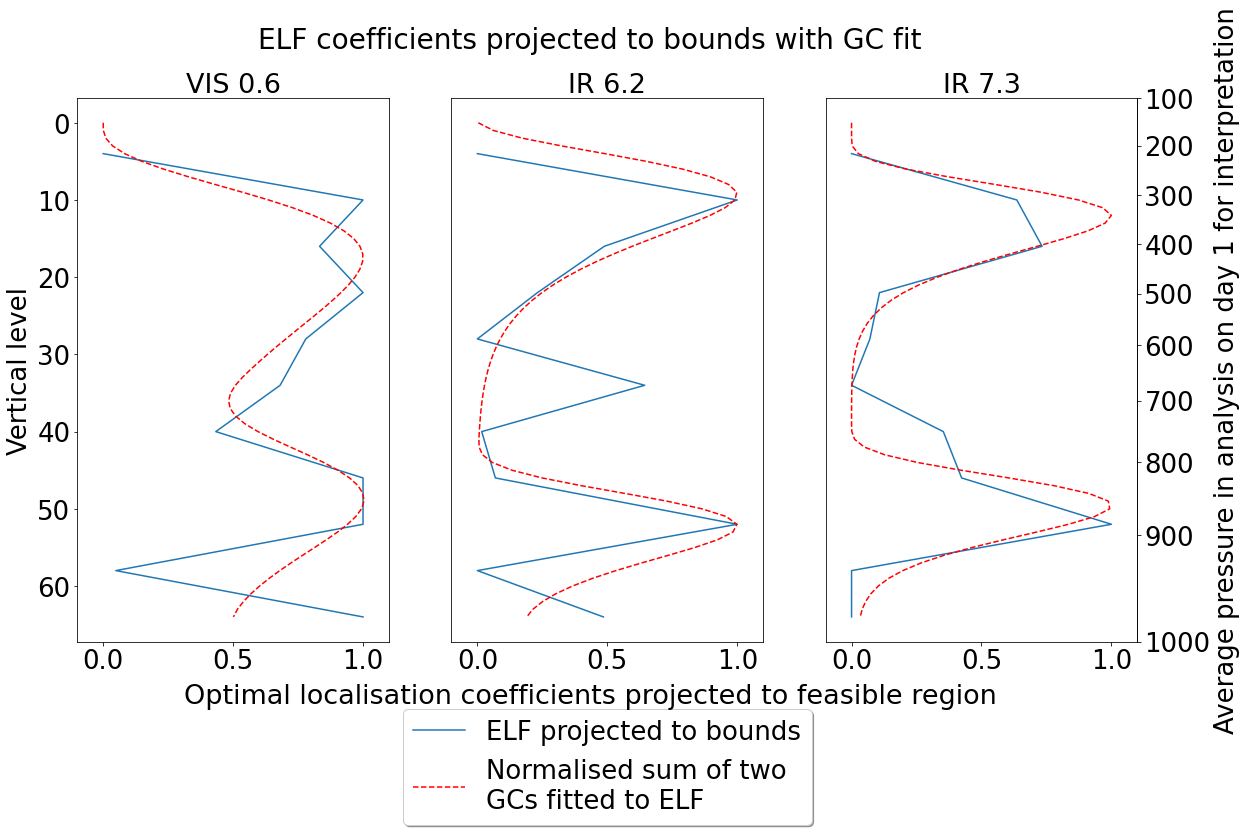

In [48]:
save_name_list1 = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/64_ELF_VIS_691215_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/64_ELF_VIS_691215_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/64_ELF_VIS_691215_21_31']
save_name_list2 = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/64_ELF_IR0_0612_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/64_ELF_IR0_0612_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/64_ELF_IR0_0612_21_31']
save_name_list3 = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/64_ELF_IR1_0612_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/64_ELF_IR1_0612_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/64_ELF_IR1_0612_21_31']
save_name_lists = [save_name_list1, save_name_list2, save_name_list3]
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
#ELF_plot_split(save_name_list, '16_05_2024_', Weights = True, constant = False, vble = 'T', save = True, plot_save_name='3REFL')
save_date = '16_05_2024_'
%matplotlib inline
ELF_plot_compare(save_name_lists, save_date, 
                 Weights = True, constant = False, 
                 vble = 'T', input_form = np.array(range(4, 65, 6)), 
                 above_threshold_name = 'Cloudy', below_threshold_name = 'Clear', threshold = 0.4, cloudvar = 'VIS', 
                 save = True, plot_save_name = 'ELF_Projected', 
                 list_choices = ['full_VIS', 'midnight', 'midnight'], 
                 Channel = 'Visible', plot_GC = True, 
                 GC_params1 = ['multi_peak', 35000, 0.5, 87000, 0.1],
                 GC_params2 = ['multi_peak', 20000, 0.45, 90000, 0.05],
                 GC_params3 = ['multi_peak', 25000, 0.3, 87000, 0.05],
                 draw_legend = True,
                 over_title='ELF coefficients projected to bounds with GC fit',
                 x_lab = 'Optimal localisation coefficients projected to feasible region')


(17913,) (17913,) (17913, 11) (349, 65) (349, 65)
(35707,) (35707,) (35707, 11) (704, 65) (704, 65)
(55683,) (55683,) (55683, 11) (1105, 65) (1105, 65)
Number Cloudy =  12778
Number Clear =  42905
(42905, 11) (12778, 11) (42905,) (12778,)
                                 WLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.005
Model:                            WLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              26.88
Date:                Tue, 30 Jul 2024   Prob (F-statistic):                    1.03e-56
Time:                        11:50:28   Log-Likelihood:                         -56272.
No. Observations:               55683   AIC:                                  1.126e+05
Df Residuals:                   55672   BIC:                                  1.127e+05
Df Model:                          11                    

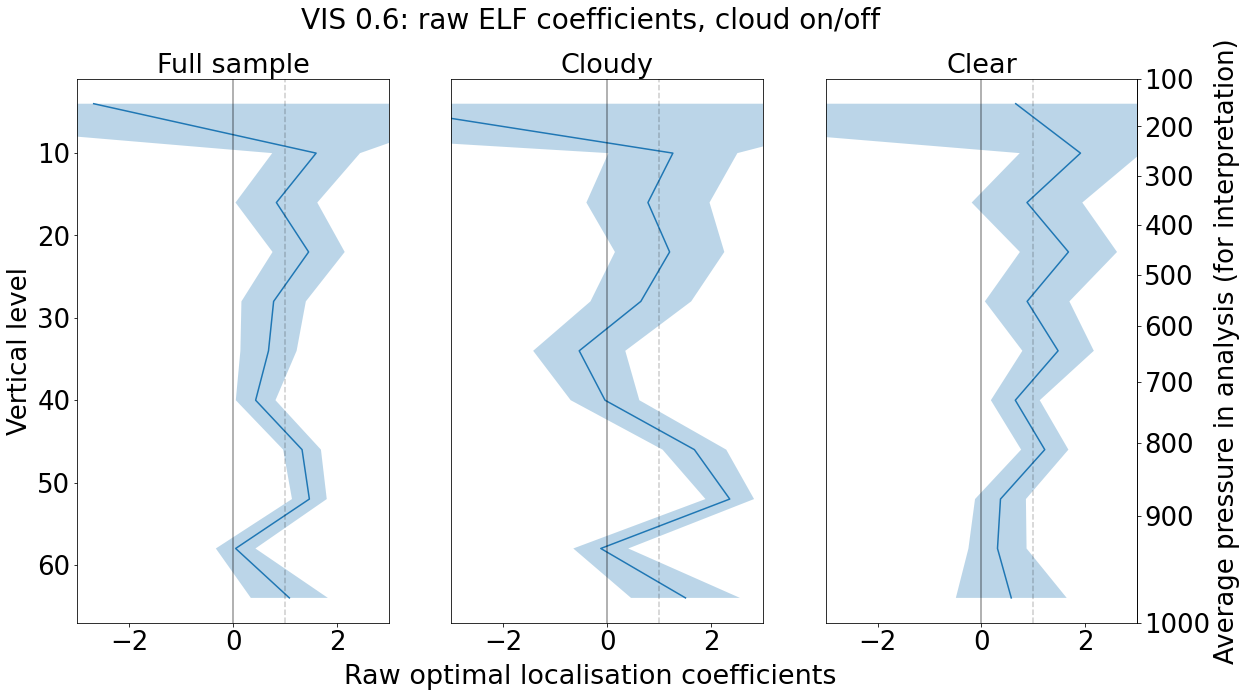

In [34]:
save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/64_ELF_VIS_691215_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/64_ELF_VIS_691215_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/64_ELF_VIS_691215_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
#ELF_plot_split(save_name_list, '16_05_2024_', Weights = True, constant = False, vble = 'T', save = True, plot_save_name='3REFL')
save_date = '16_05_2024_'
%matplotlib inline
ELF_plot_cloud_together(save_name_list, save_date, Weights = True, constant = False, vble = 'T', input_form = np.array(range(4, 65, 6)), above_threshold_name = 'Cloudy', below_threshold_name = 'Clear', threshold = 0.4, cloudvar = 'VIS', save = True, plot_save_name = 'ELF_VIS_cloud', list_choice = 'full_VIS', Channel = 'Visible', plot_GC = True, draw_legend = False, over_title = 'VIS 0.6: raw ELF coefficients, cloud on/off')


In [ ]:
%matplotlib inline
save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/64_ELF_IR0_0612_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/64_ELF_IR0_0612_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/64_ELF_IR0_0612_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
#ELF_plot_split(save_name_list, '16_05_2024_', Weights = True, constant = False, vble = 'T', save = True, plot_save_name='3REFL')
save_date = '16_05_2024_'
ELF_plot_split(save_name_list, save_date, 
               Weights = True, constant = False, vble = 'T', 
               input_form = np.array(range(4, 65, 6)), 
               above_threshold_name = 'Cloudy', below_threshold_name = 'Clear', 
               threshold = 233, cloudvar = 'IR0', 
               save = False, plot_save_name = '64_0612_IR0', 
               list_choice = 'midnight', Channel = '1st IR', 
               plot_GC = True, draw_legend = False, 
               GC_params=['multi_peak', 20000, 0.45, 90000, 0.05],
               GC_params_above=['multi_peak', 20000, 0.3, 67000, 0.1],
               GC_params_below=['multi_peak', 20000, 0.5, 90000,0.1])


midnight
(28578,) (28578,) (28578, 11) (547, 65) (547, 65)
midnight
(57953,) (57953,) (57953, 11) (1114, 65) (1114, 65)
midnight
(88789,) (88789,) (88789, 11) (1711, 65) (1711, 65)
Number Cloudy =  41424
Number Clear =  47365
(47365, 11) (41424, 11) (47365,) (41424,)
                                 WLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.004
Model:                            WLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              35.19
Date:                Tue, 30 Jul 2024   Prob (F-statistic):                    4.89e-76
Time:                        11:52:41   Log-Likelihood:                         -86966.
No. Observations:               88789   AIC:                                  1.740e+05
Df Residuals:                   88778   BIC:                                  1.741e+05
Df Model:                   

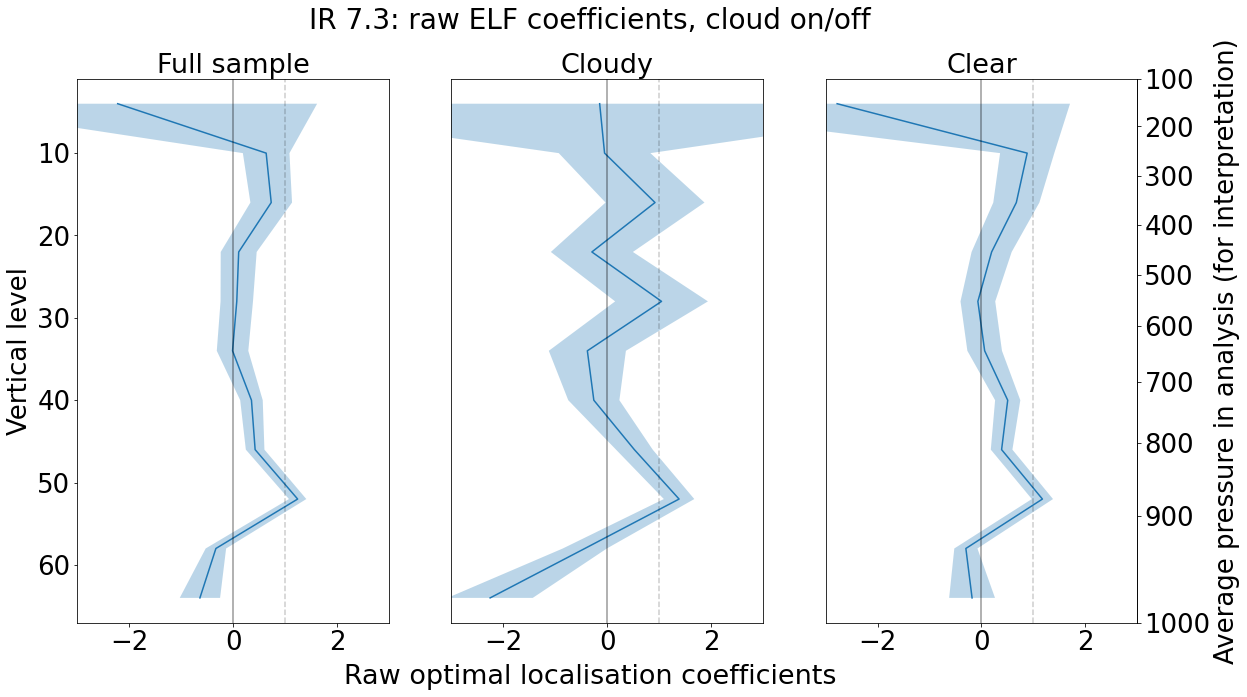

In [36]:
save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/64_ELF_IR1_0612_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/64_ELF_IR1_0612_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/64_ELF_IR1_0612_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
#ELF_plot_split(save_name_list, '16_05_2024_', Weights = True, constant = False, vble = 'T', save = True, plot_save_name='3REFL')
save_date = '16_05_2024_'
ELF_plot_cloud_together(save_name_list, save_date, 
               Weights = True, constant = False, vble = 'T', 
               input_form = np.array(range(4, 65, 6)), 
               above_threshold_name = 'Cloudy', below_threshold_name = 'Clear', 
               threshold = 252, cloudvar = 'IR1', 
               save = True, plot_save_name = 'ELF_IR1_cloud', 
               list_choice = 'midnight', Channel = '2nd IR',
               plot_GC = True, draw_legend = True,
               GC_params=['multi_peak', 25000, 0.3, 87000, 0.05],
               GC_params_above=['multi_peak', 32000, 0.15, 87000, 0.05],
               GC_params_below=['multi_peak', 25000, 0.3, 87000, 0.05],
               over_title = 'IR 7.3: raw ELF coefficients, cloud on/off')


In [ ]:
save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_IR1_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_IR1_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_IR1_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
#ELF_plot_split(save_name_list, '16_05_2024_', Weights = True, constant = False, vble = 'T', save = True, plot_save_name='3REFL')
save_date = '16_05_2024_'
%matplotlib inline
ELF_plot_split(save_name_list, save_date, Weights = True, constant = False, vble = 'T', input_form = np.array(range(0, 65, 5)), above_threshold_name = 'Clear', below_threshold_name = 'Cloudy', threshold = 240, cloudvar = 'IR1', save = True, plot_save_name = '5IR1_ELF', list_choice = 'old', Channel = '2nd IR')


In [ ]:
save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_IR0_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_IR0_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_IR0_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
#ELF_plot_split(save_name_list, '16_05_2024_', Weights = True, constant = False, vble = 'T', save = True, plot_save_name='3REFL')
save_date = '16_05_2024_'
%matplotlib inline
ELF_plot_split(save_name_list, save_date, Weights = True, constant = False, vble = 'T', input_form = np.array(range(0, 65, 5)), above_threshold_name = 'Clear', below_threshold_name = 'Cloudy', threshold = 240, cloudvar = 'IR0', save = True, plot_save_name = '5IR0', list_choice = 'old', Channel = '1st IR')


In [ ]:
save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_REFL_6_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_REFL_6_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_REFL_6_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
#ELF_plot_split(save_name_list, '16_05_2024_', Weights = True, constant = False, vble = 'T', save = True, plot_save_name='3REFL')
save_date = '16_05_2024_'
#ELF_plot2(save_name_list, save_date, Weights = True, constant = False, vble = 'T',)
#ELF_plot_cloud_on_off(save_name_list, save_date, Weights = True, constant = False, vble = 'T', input_form = np.array(range(0, 65, 5)), above_threshold_name = 'Cloudy', below_threshold_name = 'Clear', threshold = 0.4, cloudvar = 'VIS', save = True, plot_save_name = 'ELF_For_Meeting', list_choice = '6am')
ELF_plot_split(save_name_list, '16_05_2024_', Weights = True, constant = False, vble = 'T', save = True, input_form = np.array(range(0, 65, 5)), plot_save_name='5REFL', Channel = 'VIS', list_choice = '6am')


In [ ]:
save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_VIS_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_VIS_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_VIS_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
#ELF_plot_split(save_name_list, '16_05_2024_', Weights = True, constant = False, vble = 'T', save = True, plot_save_name='3REFL')
save_date = '16_05_2024_'
%matplotlib inline
#ELF_plot2(save_name_list, save_date, Weights = True, constant = False, vble = 'T',)
ELF_plot_cloud_on_off(save_name_list, save_date, Weights = True, constant = False, vble = 'T', input_form = np.array(range(0, 65, 5)), above_threshold_name = 'Cloudy', below_threshold_name = 'Clear', threshold = 0.4, cloudvar = 'VIS', save = False, plot_save_name = '', list_choice = 'old')
#ELF_plot_split(save_name_list, '16_05_2024_', Weights = True, constant = False, vble = 'T', save = True, plot_save_name='5REFL', list_choice = 'new')


In [ ]:
save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_IR1_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_IR1_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5ELF_IR1_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
#ELF_plot_split(save_name_list, '16_05_2024_', Weights = True, constant = False, vble = 'T', save = True, plot_save_name='3REFL')
save_date = '16_05_2024_'
%matplotlib inline
ELF_plot_split(save_name_list, save_date, Weights = True, constant = False, vble = 'T', input_form = np.array(range(0, 65, 5)), above_threshold_name = 'Clear', below_threshold_name = 'Cloudy', threshold = 240, cloudvar = 'IR1', save = True, plot_save_name = '5IR1_ELF', list_choice = 'old', Channel = '2nd IR')


In [ ]:
save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
ELF_plot_split(save_name_list, '16_05_2024_', Weights = True, constant = False, vble = 'T', save = True, plot_save_name='3REFL')


In [ ]:
save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_IR1_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_IR1_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_IR1_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
ELF_plot_split(save_name_list, '16_05_2024_', Weights = True, constant = False, vble = 'T', save = True, Channel = '2nd Infrared', plot_save_name='3IR1')


In [ ]:
save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_IR0_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_IR0_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_IR0_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
ELF_plot_split(save_name_list, '16_05_2024_', Weights = True, constant = False, vble = 'T', save = True, Channel = '1st Infrared', plot_save_name='3IR0')


In [ ]:
save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
#ELF_plot2(save_name_list, '16_05_2024_', Weights = True, constant = True, vble = 'T')
ELF_plot2(save_name_list, '16_05_2024_', Weights = True, constant = False, vble = 'T')


In [ ]:
save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
ELF_plot_cloud_on_off(save_name_list, '16_05_2024_', Weights = True, constant = True, vble = 'T', above_threshold_name = 'Cloudy', below_threshold_name = 'Clear', threshold = 0.4, cloudvar = 'VIS', save = True, plot_save_name='TEST_VIS_ELF_REFL04_')

save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_IR1_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_IR1_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_IR1_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
ELF_plot_cloud_on_off(save_name_list, '16_05_2024_', Weights = True, constant = True, vble = 'T', input_form = np.array(range(0, 65, 3)), above_threshold_name = 'Cloudy', below_threshold_name = 'Clear', threshold = 0.4, cloudvar = 'VIS', save = True, plot_save_name='TEST_IR1_3_ELF_REFL04_')



In [ ]:
save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
ELF_plot_cloud_on_off(save_name_list, '16_05_2024_', Weights = True, constant = True, vble = 'T', above_threshold_name = 'Cloudy', below_threshold_name = 'Clear', threshold = 0.4, cloudvar = 'VIS', save = True, plot_save_name='VIS_ELF_REFL04_')

ELF_plot_cloud_on_off(save_name_list, '16_05_2024_', Weights = True, constant = True, vble = 'T', above_threshold_name = 'Clear', below_threshold_name = 'Cloudy', threshold = 240, cloudvar = 'IR0', save = True, plot_save_name='VIS_ELF_IR0_240_')

ELF_plot_cloud_on_off(save_name_list, '16_05_2024_', Weights = True, constant = True, vble = 'T', above_threshold_name = 'Clear', below_threshold_name = 'Cloudy', threshold = 240, cloudvar = 'IR1',  save = True, plot_save_name='VIS_ELF_IR1_240_')


In [ ]:
save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/2ELF_IR0_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/2ELF_IR0_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/2ELF_IR0_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
ELF_plot_cloud_on_off(save_name_list, '16_05_2024_', Weights = True, constant = True, vble = 'T', input_form = np.array(range(0, 65, 2)), above_threshold_name = 'Cloudy', below_threshold_name = 'Clear', threshold = 0.4, cloudvar = 'VIS', save = True, plot_save_name='IR0_ELF_REFL04_')

ELF_plot_cloud_on_off(save_name_list, '16_05_2024_', Weights = True, constant = True, vble = 'T', input_form = np.array(range(0, 65, 2)), above_threshold_name = 'Clear', below_threshold_name = 'Cloudy', threshold = 240, cloudvar = 'IR0', save = True, plot_save_name='IR0_ELF_IR0_240_')

ELF_plot_cloud_on_off(save_name_list, '16_05_2024_', Weights = True, constant = True, vble = 'T', input_form = np.array(range(0, 65, 2)), above_threshold_name = 'Clear', below_threshold_name = 'Cloudy', threshold = 240, cloudvar = 'IR1',  save = True, plot_save_name='IR0_ELF_IR1_240_')


In [ ]:
save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_IR1_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_IR1_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_IR1_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
ELF_plot_cloud_on_off(save_name_list, '16_05_2024_', Weights = True, constant = True, vble = 'T', input_form = np.array(range(0, 65, 3)), above_threshold_name = 'Cloudy', below_threshold_name = 'Clear', threshold = 0.4, cloudvar = 'VIS', save = True, plot_save_name='IR1_3_ELF_REFL04_')

ELF_plot_cloud_on_off(save_name_list, '16_05_2024_', Weights = True, constant = True, vble = 'T', input_form = np.array(range(0, 65, 3)), above_threshold_name = 'Clear', below_threshold_name = 'Cloudy', threshold = 240, cloudvar = 'IR0', save = True, plot_save_name='IR1_3_ELF_IR0_240_')

ELF_plot_cloud_on_off(save_name_list, '16_05_2024_', Weights = True, constant = True, vble = 'T', input_form = np.array(range(0, 65, 3)), above_threshold_name = 'Clear', below_threshold_name = 'Cloudy', threshold = 240, cloudvar = 'IR1',  save = True, plot_save_name='IR1_3_ELF_IR1_240_')


In [ ]:
save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_IR0_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_IR0_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_IR0_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
ELF_plot_cloud_on_off(save_name_list, '16_05_2024_', Weights = True, constant = True, vble = 'T', input_form = np.array(range(0, 65, 3)), above_threshold_name = 'Cloudy', below_threshold_name = 'Clear', threshold = 0.4, cloudvar = 'VIS', save = True, plot_save_name='IR0_3_ELF_REFL04_')

ELF_plot_cloud_on_off(save_name_list, '16_05_2024_', Weights = True, constant = True, vble = 'T', input_form = np.array(range(0, 65, 3)), above_threshold_name = 'Clear', below_threshold_name = 'Cloudy', threshold = 240, cloudvar = 'IR0', save = True, plot_save_name='IR0_3_ELF_IR0_240_')

ELF_plot_cloud_on_off(save_name_list, '16_05_2024_', Weights = True, constant = True, vble = 'T', input_form = np.array(range(0, 65, 3)), above_threshold_name = 'Clear', below_threshold_name = 'Cloudy', threshold = 240, cloudvar = 'IR1',  save = True, plot_save_name='IR0_3_ELF_IR1_240_')


In [ ]:
save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
ELF_plot_cloud_on_off(save_name_list, '16_05_2024_', Weights = True, constant = True, vble = 'T')

save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
ELF_plot_cloud_on_off(save_name_list, '16_05_2024_', Weights = True, constant = True, vble = 'T', above_threshold_name = 'Clear', below_threshold_name = 'Cloudy', threshold = 240, cloudvar = 'IR0')

save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_01_11',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_11_21',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/3ELF_21_31']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
ELF_plot_cloud_on_off(save_name_list, '16_05_2024_', Weights = True, constant = True, vble = 'T', above_threshold_name = 'Clear', below_threshold_name = 'Cloudy', threshold = 240, cloudvar = 'IR1')


In [ ]:
save_name_list = ['/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/ELF_1_10',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/ELF_11_20',
                                '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/ELF_21_30']
exp_path = '/jetfs/shared-data/ICON-LAM-DWD/exp_2'
ELF_plot2(save_name_list, '16_05_2024_', Weights = True, constant = True, vble = 'T')
ELF_plot2(save_name_list, '16_05_2024_', Weights = True, constant = False, vble = 'T')


In [ ]:
e_o_list_T = []
e_o_list_Q = []
VIS_list_T = []
VIS_list_Q = []
IR1_list_T = []
IR1_list_Q = []
IR2_list_T = []
IR2_list_Q = []
raw_y_list = []
exp_path ='/jetfs/shared-data/ICON-LAM-DWD/exp_2'
save_date = '16_05_2024_'
save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_6_ELF_11_21'
ana_days = [f'202306{str(i).zfill(2)}' for i in range(11, 21)]
vars = ['t', 'q']
inf_ds_full = xr.open_dataset('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/RTPP_influences_full2')

#failure_list = np.load(save_name + '_failures_' + save_date + ana_time + '.npy')
#failure_list = [('20230603120000', 7), ('20230602120000', 8), ('20230601120000', 8)]
for ana_day in ana_days: # 
    for Time in [6, 12]:
        if Time == 6:
            dir_time = ana_day + '060000'
            dir_time2 = ana_day + '030000'
            ana_time = ana_day + '060000'
            sonde_time = ana_day + '050000'
        elif Time == 12:
            dir_time = ana_day + '120000'
            dir_time2 = ana_day + '090000'
            ana_time = ana_day + '120000'
            sonde_time = ana_day + '110000'
        obs_path_RAD = '{}/feedback/{}/ekfRAD.nc.{}'.format(exp_path, dir_time, ana_time)
        obs_path_TEMP1 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, dir_time2, sonde_time)
        obs_path_TEMP2 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, ana_time, ana_time)
        #ana_path = '{}/{}/an_R19B07.{}.mean'.format(exp_path, ana_time, ana_time)
        sondes_RH1 = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
        sondes_T1 = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
        sondes_RH2 = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
        sondes_T2 = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
        #mean = paiut.read_grib(ana_path, vars) 
        for i in range(len(sondes_T1.reports()) + len(sondes_T2.reports())): #range(len(sondes_T.reports())):
            start_time = time.time()
            if i < len(sondes_T1.reports()):
                rep = sondes_T1.reports()[i]
                obs_sonde_RH = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
                obs_sonde_T = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
            else:
                rep = sondes_T2.reports()[i - len(sondes_T1.reports())]
                obs_sonde_RH = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
                obs_sonde_T = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
            obs_sonde_RH.add_filter(filter=f"report={rep}")
            obs_sonde_T.add_filter(filter=f"report={rep}")
            obslon = obs_sonde_T.obs(param="lon")[0]
            obslat = obs_sonde_T.obs(param="lat")[0]
            print(f"Day {ana_time}, Sonde {i}, report {rep}")
            infl_reg_latlon = get_local_regions(obslon, obslat, h_loc=25.0)
            #[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]
            print("get obs batch")
            obs_batch = paiut.get_obs_batch(obs_path_RAD, *infl_reg_latlon, obsvar="REFL", new_loc = False, RAWBT_choice=1)
            print(len(obs_batch))
            if len(obs_batch) == 0:
                print('NO SATELLITE OBS HERE')
                continue
            if os.path.isfile('/jetfs/home/a12233665/pai-munich-vienna/Analysis_Forecast_Pert_Files/tilde_X_a_' + ana_time + '_' + str(i)) == False:
                continue
            VIS_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['REFL_value'].values[0]
            IR1_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean1'].values[0]
            IR2_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean2'].values[0]
            e_o_list_T.append(obs_sonde_T.obs(param="e_o"))
            e_o_list_Q.append(obs_sonde_RH.obs(param="e_o"))
            VIS_list_T.append(VIS_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            VIS_list_Q.append(VIS_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
            IR1_list_T.append(IR1_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            IR1_list_Q.append(IR1_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
            IR2_list_T.append(IR2_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            IR2_list_Q.append(IR2_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))

np.save(save_name + '_e_o_Ts_' + save_date, np.array(np.concatenate(e_o_list_T)))
np.save(save_name + '_e_o_Qs_' + save_date, np.array(np.concatenate(e_o_list_Q)))
np.save(save_name + '_VIS_T_' + save_date, np.array(np.concatenate(VIS_list_T)))
np.save(save_name + '_IR1_T_' + save_date, np.array(np.concatenate(IR1_list_T)))
np.save(save_name + '_IR2_T_' + save_date, np.array(np.concatenate(IR2_list_T)))


In [ ]:
e_o_list_T = []
e_o_list_Q = []
VIS_list_T = []
VIS_list_Q = []
IR1_list_T = []
IR1_list_Q = []
IR2_list_T = []
IR2_list_Q = []
raw_y_list = []
exp_path ='/jetfs/shared-data/ICON-LAM-DWD/exp_2'
save_date = '16_05_2024_'
save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_6_ELF_11_21'
ana_days = [f'202306{str(i).zfill(2)}' for i in range(11, 21)]
vars = ['t', 'q']
inf_ds_full = xr.open_dataset('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/RTPP_influences_full2')

#failure_list = np.load(save_name + '_failures_' + save_date + ana_time + '.npy')
#failure_list = [('20230603120000', 7), ('20230602120000', 8), ('20230601120000', 8)]
for ana_day in ana_days: # 
    for Time in [6, 12]:
        if Time == 6:
            dir_time = ana_day + '060000'
            dir_time2 = ana_day + '030000'
            ana_time = ana_day + '060000'
            sonde_time = ana_day + '050000'
        elif Time == 12:
            dir_time = ana_day + '120000'
            dir_time2 = ana_day + '090000'
            ana_time = ana_day + '120000'
            sonde_time = ana_day + '110000'
        obs_path_RAD = '{}/feedback/{}/ekfRAD.nc.{}'.format(exp_path, dir_time, ana_time)
        obs_path_TEMP1 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, dir_time2, sonde_time)
        obs_path_TEMP2 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, ana_time, ana_time)
        #ana_path = '{}/{}/an_R19B07.{}.mean'.format(exp_path, ana_time, ana_time)
        sondes_RH1 = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
        sondes_T1 = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
        sondes_RH2 = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
        sondes_T2 = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
        #mean = paiut.read_grib(ana_path, vars) 
        for i in range(len(sondes_T1.reports()) + len(sondes_T2.reports())): #range(len(sondes_T.reports())):
            start_time = time.time()
            if i < len(sondes_T1.reports()):
                rep = sondes_T1.reports()[i]
                obs_sonde_RH = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
                obs_sonde_T = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
            else:
                rep = sondes_T2.reports()[i - len(sondes_T1.reports())]
                obs_sonde_RH = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
                obs_sonde_T = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
            obs_sonde_RH.add_filter(filter=f"report={rep}")
            obs_sonde_T.add_filter(filter=f"report={rep}")
            obslon = obs_sonde_T.obs(param="lon")[0]
            obslat = obs_sonde_T.obs(param="lat")[0]
            print(f"Day {ana_time}, Sonde {i}, report {rep}")
            infl_reg_latlon = get_local_regions(obslon, obslat, h_loc=25.0)
            #[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]
            print("get obs batch")
            obs_batch = paiut.get_obs_batch(obs_path_RAD, *infl_reg_latlon, obsvar="REFL", new_loc = False, RAWBT_choice=0)
            print(len(obs_batch))
            if len(obs_batch) == 0:
                print('NO SATELLITE OBS HERE')
                continue
            if os.path.isfile('/jetfs/home/a12233665/pai-munich-vienna/Analysis_Forecast_Pert_Files/tilde_X_a_' + ana_time + '_' + str(i)) == False:
                continue
            VIS_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['REFL_value'].values[0]
            IR1_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean1'].values[0]
            IR2_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean2'].values[0]
            e_o_list_T.append(obs_sonde_T.obs(param="e_o"))
            e_o_list_Q.append(obs_sonde_RH.obs(param="e_o"))
            VIS_list_T.append(VIS_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            VIS_list_Q.append(VIS_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
            IR1_list_T.append(IR1_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            IR1_list_Q.append(IR1_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
            IR2_list_T.append(IR2_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            IR2_list_Q.append(IR2_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))

np.save(save_name + '_e_o_Ts_' + save_date, np.array(np.concatenate(e_o_list_T)))
np.save(save_name + '_e_o_Qs_' + save_date, np.array(np.concatenate(e_o_list_Q)))
np.save(save_name + '_VIS_T_' + save_date, np.array(np.concatenate(VIS_list_T)))
np.save(save_name + '_IR1_T_' + save_date, np.array(np.concatenate(IR1_list_T)))
np.save(save_name + '_IR2_T_' + save_date, np.array(np.concatenate(IR2_list_T)))


In [ ]:
e_o_list_T = []
e_o_list_Q = []
VIS_list_T = []
VIS_list_Q = []
IR1_list_T = []
IR1_list_Q = []
IR2_list_T = []
IR2_list_Q = []
raw_y_list = []
exp_path ='/jetfs/shared-data/ICON-LAM-DWD/exp_2'
save_date = '16_05_2024_'
save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_6_ELF_21_31'
ana_days = [f'202306{str(i).zfill(2)}' for i in range(21, 31)]
vars = ['t', 'q']
inf_ds_full = xr.open_dataset('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/RTPP_influences_full2')

#failure_list = np.load(save_name + '_failures_' + save_date + ana_time + '.npy')
#failure_list = [('20230603120000', 7), ('20230602120000', 8), ('20230601120000', 8)]
for ana_day in ana_days: # 
    for Time in [6, 12]:
        if Time == 6:
            dir_time = ana_day + '060000'
            dir_time2 = ana_day + '030000'
            ana_time = ana_day + '060000'
            sonde_time = ana_day + '050000'
        elif Time == 12:
            dir_time = ana_day + '120000'
            dir_time2 = ana_day + '090000'
            ana_time = ana_day + '120000'
            sonde_time = ana_day + '110000'
        obs_path_RAD = '{}/feedback/{}/ekfRAD.nc.{}'.format(exp_path, dir_time, ana_time)
        obs_path_TEMP1 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, dir_time2, sonde_time)
        obs_path_TEMP2 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, ana_time, ana_time)
        #ana_path = '{}/{}/an_R19B07.{}.mean'.format(exp_path, ana_time, ana_time)
        sondes_RH1 = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
        sondes_T1 = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
        sondes_RH2 = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
        sondes_T2 = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
        #mean = paiut.read_grib(ana_path, vars) 
        for i in range(len(sondes_T1.reports()) + len(sondes_T2.reports())): #range(len(sondes_T.reports())):
            start_time = time.time()
            if i < len(sondes_T1.reports()):
                rep = sondes_T1.reports()[i]
                obs_sonde_RH = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
                obs_sonde_T = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
            else:
                rep = sondes_T2.reports()[i - len(sondes_T1.reports())]
                obs_sonde_RH = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
                obs_sonde_T = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
            obs_sonde_RH.add_filter(filter=f"report={rep}")
            obs_sonde_T.add_filter(filter=f"report={rep}")
            obslon = obs_sonde_T.obs(param="lon")[0]
            obslat = obs_sonde_T.obs(param="lat")[0]
            print(f"Day {ana_time}, Sonde {i}, report {rep}")
            infl_reg_latlon = get_local_regions(obslon, obslat, h_loc=25.0)
            #[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]
            print("get obs batch")
            obs_batch = paiut.get_obs_batch(obs_path_RAD, *infl_reg_latlon, obsvar="REFL", new_loc = False, RAWBT_choice=0)
            print(len(obs_batch))
            if len(obs_batch) == 0:
                print('NO SATELLITE OBS HERE')
                continue
            if os.path.isfile('/jetfs/home/a12233665/pai-munich-vienna/Analysis_Forecast_Pert_Files/tilde_X_a_' + ana_time + '_' + str(i)) == False:
                continue
            VIS_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['REFL_value'].values[0]
            IR1_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean1'].values[0]
            IR2_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean2'].values[0]
            e_o_list_T.append(obs_sonde_T.obs(param="e_o"))
            e_o_list_Q.append(obs_sonde_RH.obs(param="e_o"))
            VIS_list_T.append(VIS_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            VIS_list_Q.append(VIS_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
            IR1_list_T.append(IR1_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            IR1_list_Q.append(IR1_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
            IR2_list_T.append(IR2_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            IR2_list_Q.append(IR2_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))

np.save(save_name + '_e_o_Ts_' + save_date, np.array(np.concatenate(e_o_list_T)))
np.save(save_name + '_e_o_Qs_' + save_date, np.array(np.concatenate(e_o_list_Q)))
np.save(save_name + '_VIS_T_' + save_date, np.array(np.concatenate(VIS_list_T)))
np.save(save_name + '_IR1_T_' + save_date, np.array(np.concatenate(IR1_list_T)))
np.save(save_name + '_IR2_T_' + save_date, np.array(np.concatenate(IR2_list_T)))


In [ ]:
e_o_list_T = []
e_o_list_Q = []
VIS_list_T = []
VIS_list_Q = []
IR1_list_T = []
IR1_list_Q = []
IR2_list_T = []
IR2_list_Q = []
raw_y_list = []
exp_path ='/jetfs/shared-data/ICON-LAM-DWD/exp_2'
save_date = '16_05_2024_'
save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5IR1ELF_01_11'
ana_days = [f'202306{str(i).zfill(2)}' for i in range(1, 11)]
vars = ['t', 'q']
inf_ds_full = xr.open_dataset('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/RTPP_influences_full')

#failure_list = np.load(save_name + '_failures_' + save_date + ana_time + '.npy')
#failure_list = [('20230603120000', 7), ('20230602120000', 8), ('20230601120000', 8)]
for ana_day in ana_days: # 
    dir_time = ana_day + '120000'
    dir_time2 = ana_day + '090000'
    ana_time = ana_day + '120000'
    sonde_time = ana_day + '110000'
    obs_path_RAD = '{}/feedback/{}/ekfRAD.nc.{}'.format(exp_path, dir_time, ana_time)
    obs_path_TEMP1 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, dir_time2, sonde_time)
    obs_path_TEMP2 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, ana_time, ana_time)
    ana_path = '{}/{}/an_R19B07.{}.mean'.format(exp_path, ana_time, ana_time)
    sondes_RH1 = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
    sondes_T1 = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
    sondes_RH2 = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
    sondes_T2 = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
    mean = paiut.read_grib(ana_path, vars) 
    for i in range(len(sondes_T1.reports()) + len(sondes_T2.reports())): #range(len(sondes_T.reports())):
        start_time = time.time()
        if i < len(sondes_T1.reports()):
            rep = sondes_T1.reports()[i]
            obs_sonde_RH = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
            obs_sonde_T = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
        else:
            rep = sondes_T2.reports()[i - len(sondes_T1.reports())]
            obs_sonde_RH = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
            obs_sonde_T = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
        obs_sonde_RH.add_filter(filter=f"report={rep}")
        obs_sonde_T.add_filter(filter=f"report={rep}")
        obslon = obs_sonde_T.obs(param="lon")[0]
        obslat = obs_sonde_T.obs(param="lat")[0]
        print(f"Day {ana_time}, Sonde {i}, report {rep}")
        infl_reg_latlon = get_local_regions(obslon, obslat, h_loc=25.0)
        #[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]
        print("get obs batch")
        obs_batch = paiut.get_obs_batch(obs_path_RAD, *infl_reg_latlon, obsvar="RAWBT", new_loc = False, RAWBT_choice=1)
        print(len(obs_batch))
        buffer = 0.04
        mean2 = loc.find_analysis_in_area(obslon - buffer, obslon + buffer, obslat - buffer, obslat + buffer, mean.clon, mean.clat, mean)
        mean2 = mean2.isel(time=0)
        if len(obs_batch) == 0:
            print('NO SATELLITE OBS HERE')
            continue
        if mean2.t.shape[1] == 0:
            print('NO ANALYSIS HERE')
            continue
        if os.path.isfile('/jetfs/home/a12233665/pai-munich-vienna/Analysis_Forecast_Pert_Files/tilde_X_a_' + ana_time + '_' + str(i)) == False:
            continue
        VIS_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.rep_num==i), drop = True)['REFL_value'].values[0]
        IR1_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean1'].values[0]
        IR2_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean2'].values[0]
        e_o_list_T.append(obs_sonde_T.obs(param="e_o"))
        e_o_list_Q.append(obs_sonde_RH.obs(param="e_o"))
        VIS_list_T.append(VIS_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
        VIS_list_Q.append(VIS_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
        IR1_list_T.append(IR1_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
        IR1_list_Q.append(IR1_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
        IR2_list_T.append(IR2_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
        IR2_list_Q.append(IR2_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))

np.save(save_name + '_e_o_Ts_' + save_date, np.array(np.concatenate(e_o_list_T)))
np.save(save_name + '_e_o_Qs_' + save_date, np.array(np.concatenate(e_o_list_Q)))
np.save(save_name + '_VIS_T_' + save_date, np.array(np.concatenate(VIS_list_T)))
np.save(save_name + '_IR1_T_' + save_date, np.array(np.concatenate(IR1_list_T)))
np.save(save_name + '_IR2_T_' + save_date, np.array(np.concatenate(IR2_list_T)))


In [ ]:
e_o_list_T = []
e_o_list_Q = []
VIS_list_T = []
VIS_list_Q = []
IR1_list_T = []
IR1_list_Q = []
IR2_list_T = []
IR2_list_Q = []
raw_y_list = []
exp_path ='/jetfs/shared-data/ICON-LAM-DWD/exp_2'
save_date = '16_05_2024_'
save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5IR1ELF_11_21'
ana_days = [f'202306{str(i).zfill(2)}' for i in range(11, 21)]
vars = ['t', 'q']
inf_ds_full = xr.open_dataset('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/RTPP_influences_full')

#failure_list = np.load(save_name + '_failures_' + save_date + ana_time + '.npy')
#failure_list = [('20230603120000', 7), ('20230602120000', 8), ('20230601120000', 8)]
for ana_day in ana_days: # 
    dir_time = ana_day + '120000'
    dir_time2 = ana_day + '090000'
    ana_time = ana_day + '120000'
    sonde_time = ana_day + '110000'
    obs_path_RAD = '{}/feedback/{}/ekfRAD.nc.{}'.format(exp_path, dir_time, ana_time)
    obs_path_TEMP1 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, dir_time2, sonde_time)
    obs_path_TEMP2 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, ana_time, ana_time)
    ana_path = '{}/{}/an_R19B07.{}.mean'.format(exp_path, ana_time, ana_time)
    sondes_RH1 = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
    sondes_T1 = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
    sondes_RH2 = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
    sondes_T2 = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
    mean = paiut.read_grib(ana_path, vars) 
    for i in range(len(sondes_T1.reports()) + len(sondes_T2.reports())): #range(len(sondes_T.reports())):
        start_time = time.time()
        if i < len(sondes_T1.reports()):
            rep = sondes_T1.reports()[i]
            obs_sonde_RH = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
            obs_sonde_T = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
        else:
            rep = sondes_T2.reports()[i - len(sondes_T1.reports())]
            obs_sonde_RH = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
            obs_sonde_T = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
        obs_sonde_RH.add_filter(filter=f"report={rep}")
        obs_sonde_T.add_filter(filter=f"report={rep}")
        obslon = obs_sonde_T.obs(param="lon")[0]
        obslat = obs_sonde_T.obs(param="lat")[0]
        print(f"Day {ana_time}, Sonde {i}, report {rep}")
        infl_reg_latlon = get_local_regions(obslon, obslat, h_loc=25.0)
        #[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]
        print("get obs batch")
        obs_batch = paiut.get_obs_batch(obs_path_RAD, *infl_reg_latlon, obsvar="RAWBT", new_loc = False, RAWBT_choice=1)
        print(len(obs_batch))
        buffer = 0.04
        mean2 = loc.find_analysis_in_area(obslon - buffer, obslon + buffer, obslat - buffer, obslat + buffer, mean.clon, mean.clat, mean)
        mean2 = mean2.isel(time=0)
        if len(obs_batch) == 0:
            print('NO SATELLITE OBS HERE')
            continue
        if mean2.t.shape[1] == 0:
            print('NO ANALYSIS HERE')
            continue
        if os.path.isfile('/jetfs/home/a12233665/pai-munich-vienna/Analysis_Forecast_Pert_Files/tilde_X_a_' + ana_time + '_' + str(i)) == False:
            continue
        VIS_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.rep_num==i), drop = True)['REFL_value'].values[0]
        IR1_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean1'].values[0]
        IR2_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean2'].values[0]
        e_o_list_T.append(obs_sonde_T.obs(param="e_o"))
        e_o_list_Q.append(obs_sonde_RH.obs(param="e_o"))
        VIS_list_T.append(VIS_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
        VIS_list_Q.append(VIS_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
        IR1_list_T.append(IR1_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
        IR1_list_Q.append(IR1_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
        IR2_list_T.append(IR2_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
        IR2_list_Q.append(IR2_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))

np.save(save_name + '_e_o_Ts_' + save_date, np.array(np.concatenate(e_o_list_T)))
np.save(save_name + '_e_o_Qs_' + save_date, np.array(np.concatenate(e_o_list_Q)))
np.save(save_name + '_VIS_T_' + save_date, np.array(np.concatenate(VIS_list_T)))
np.save(save_name + '_IR1_T_' + save_date, np.array(np.concatenate(IR1_list_T)))
np.save(save_name + '_IR2_T_' + save_date, np.array(np.concatenate(IR2_list_T)))


In [ ]:
e_o_list_T = []
e_o_list_Q = []
VIS_list_T = []
VIS_list_Q = []
IR1_list_T = []
IR1_list_Q = []
IR2_list_T = []
IR2_list_Q = []
raw_y_list = []
exp_path ='/jetfs/shared-data/ICON-LAM-DWD/exp_2'
save_date = '16_05_2024_'
save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5IR1ELF_21_31'
ana_days = [f'202306{str(i).zfill(2)}' for i in range(21, 31)]
vars = ['t', 'q']
inf_ds_full = xr.open_dataset('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/RTPP_influences_full')

#failure_list = np.load(save_name + '_failures_' + save_date + ana_time + '.npy')
#failure_list = [('20230603120000', 7), ('20230602120000', 8), ('20230601120000', 8)]
for ana_day in ana_days: # 
    dir_time = ana_day + '120000'
    dir_time2 = ana_day + '090000'
    ana_time = ana_day + '120000'
    sonde_time = ana_day + '110000'
    obs_path_RAD = '{}/feedback/{}/ekfRAD.nc.{}'.format(exp_path, dir_time, ana_time)
    obs_path_TEMP1 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, dir_time2, sonde_time)
    obs_path_TEMP2 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, ana_time, ana_time)
    #ana_path = '{}/{}/an_R19B07.{}.mean'.format(exp_path, ana_time, ana_time)
    sondes_RH1 = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
    sondes_T1 = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
    sondes_RH2 = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
    sondes_T2 = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
    #mean = paiut.read_grib(ana_path, vars) 
    for i in range(len(sondes_T1.reports()) + len(sondes_T2.reports())): #range(len(sondes_T.reports())):
        start_time = time.time()
        if i < len(sondes_T1.reports()):
            rep = sondes_T1.reports()[i]
            obs_sonde_RH = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
            obs_sonde_T = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
        else:
            rep = sondes_T2.reports()[i - len(sondes_T1.reports())]
            obs_sonde_RH = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
            obs_sonde_T = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
        obs_sonde_RH.add_filter(filter=f"report={rep}")
        obs_sonde_T.add_filter(filter=f"report={rep}")
        obslon = obs_sonde_T.obs(param="lon")[0]
        obslat = obs_sonde_T.obs(param="lat")[0]
        print(f"Day {ana_time}, Sonde {i}, report {rep}")
        infl_reg_latlon = get_local_regions(obslon, obslat, h_loc=25.0)
        #[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]
        print("get obs batch")
        obs_batch = paiut.get_obs_batch(obs_path_RAD, *infl_reg_latlon, obsvar="RAWBT", new_loc = False, RAWBT_choice=1)
        print(len(obs_batch))
        if len(obs_batch) == 0:
            print('NO SATELLITE OBS HERE')
            continue
        if os.path.isfile('/jetfs/home/a12233665/pai-munich-vienna/Analysis_Forecast_Pert_Files/tilde_X_a_' + ana_time + '_' + str(i)) == False:
            continue
        VIS_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.rep_num==i), drop = True)['REFL_value'].values[0]
        IR1_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean1'].values[0]
        IR2_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean2'].values[0]
        e_o_list_T.append(obs_sonde_T.obs(param="e_o"))
        e_o_list_Q.append(obs_sonde_RH.obs(param="e_o"))
        VIS_list_T.append(VIS_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
        VIS_list_Q.append(VIS_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
        IR1_list_T.append(IR1_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
        IR1_list_Q.append(IR1_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
        IR2_list_T.append(IR2_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
        IR2_list_Q.append(IR2_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))

np.save(save_name + '_e_o_Ts_' + save_date, np.array(np.concatenate(e_o_list_T)))
np.save(save_name + '_e_o_Qs_' + save_date, np.array(np.concatenate(e_o_list_Q)))
np.save(save_name + '_VIS_T_' + save_date, np.array(np.concatenate(VIS_list_T)))
np.save(save_name + '_IR1_T_' + save_date, np.array(np.concatenate(IR1_list_T)))
np.save(save_name + '_IR2_T_' + save_date, np.array(np.concatenate(IR2_list_T)))


In [ ]:
W_Ts = np.load(save_name + '_e_o_Ts_' + save_date + '.npy')
X = np.load(save_name + '_C_Ts_' + save_date + '.npy').T

In [ ]:
print(W_Ts.shape, X.shape)

In [ ]:
ELF_plot2(save_name_list, '16_05_2024_', Weights = False, constant = True, vble = 'RH')
ELF_plot2(save_name_list, '16_05_2024_', Weights = False, constant = False, vble = 'RH')

In [ ]:
exp_path ='/jetfs/shared-data/ICON-LAM-DWD'
save_date = '16_04_2024_'
save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results/fof'

In [ ]:
#Profile to see what takes longest:
pr = cProfile.Profile()
pr.enable()
C_list_T = [] #List of C matrices for each radiosonde, ready to concatenate and manipulate.
C_list_Q = []
dy_list_T = [] #List of dy vectors for each radiosonde, ready to concatenate and manipulate.
dy_list_Q = []
e_o_list = []
incr_list_T = []
mean_list_T = []
incr_list_Q = []
mean_list_Q = []
failure_list = [] #List of radiosonde locations where there were not enough observations to analyse.#
ana_days = [f'202306{str(i).zfill(2)}' for i in range(1, 25)]
for ana_day in ana_days: # 
    dir_time = ana_day + '120000'
    ana_time = ana_day + '120000'
    veri_time = ana_day + '110000'
    obs_path_RAD = '{}/feedback/{}/ekfRAD.nc.{}'.format(exp_path, ana_time, ana_time)
    obs_path_TEMP = '{}/{}/fofTEMP_{}.nc'.format(exp_path, dir_time, veri_time)
    ana_path = '{}/{}/an_R19B07.{}.mean'.format(exp_path, ana_time, ana_time)
    #Get list of radiosondes to test against.
    sondes_RH = paiut.get_ekf(obs_path_TEMP, "RH")
    sondes_T = paiut.get_ekf(obs_path_TEMP, "T")
    vars = ['t', 'q']
    #Ready to store errors. Will be a list of lists, where each list corresponds to a radiosonde and the elements are the errors for each pressure level/nominal height.
    #Maybe read within loop. Depends on memory.
    print("read big data files")
    mean = paiut.read_grib(ana_path, vars) 
    ens = paiut.read_grib_mf(ana_path, ana_time, vars)
    for i in range(len(sondes_T.reports())):
        #Retrieve information for individual report.
        rep = sondes_T.reports()[i]
        obs_sonde_RH = paiut.get_ekf(obs_path_TEMP, "RH")
        obs_sonde_T = paiut.get_ekf(obs_path_TEMP, "T")
        obs_sonde_RH.add_filter(filter=f"report={rep}")
        obs_sonde_T.add_filter(filter=f"report={rep}")
        obslon = obs_sonde_T.obs(param="lon")[0]
        obslat = obs_sonde_T.obs(param="lat")[0]
    
        print(f"Day {ana_time}, Sonde {i}, report {rep}, lat {obslat}, lon {obslon}")
        infl_reg_latlon = get_local_regions(obslon, obslat, h_loc=25.0)
        #[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]
        print("get obs batch")
        obs_batch = paiut.get_obs_batch(obs_path_RAD, *infl_reg_latlon, obsvar="REFL", new_loc = False)
        print(len(obs_batch))
        if len(obs_batch) == 0:
            print('NO SATELLITE OBS HERE')
            failure_list.append((ana_time, i))
            continue
        print("isolate data")
        #mean = paiut.read_grib(ana_path, vars) 
        #ens = paiut.read_grib_mf(ana_path, ana_time, vars) 
        var = 't'
        buffer = 0.075
        ens2 = find_analysis_in_area(obslon - buffer, obslon + buffer, obslat - buffer, obslat + buffer, ens.clon, ens.clat, ens)
        mean2 = find_analysis_in_area(obslon - buffer, obslon + buffer, obslat - buffer, obslat + buffer, mean.clon, mean.clat, mean)
        ensperturb = ens2 - mean2
        print(len(ensperturb.cell))
        if mean2.t.shape[2] == 0:
            print('NO ANALYSIS HERE')
            failure_list.append((ana_time, i))
            continue
        #del mean
        #del ens

        #Extract values now so that we don't need to every time we call PAI.
        pressure_levels = mean2.pres.isel(time=0).values
        lats = ensperturb.clat.values
        lons = ensperturb.clon.values
        perturbvars = [ensperturb.isel(time = 0)[var].values for var in vars]
        perturbvars.append(ensperturb.isel(time = 0).pres.values)
        #Get actual increment (approximated by PAI) attributed to radiances in this area (for error calculations later).
        print('get PAI')
        #for obs in obs_batch:
        #    obs['vloc'] = 20
        #    obs['obspres'] = 70000
        incr_standard = pai_loop_over_obs_slow(
                obs_batch,
                ['t', 'q', 'pres'],
                lons,
                lats,
                perturbvars,
                pressure_levels,
                40,
            )
        incr_standard_T = incr_standard[0][1]
        incr_standard_Q = incr_standard[1][1]
        incr_standard_P = incr_standard[2][1]#incr_noloc_P = incr_noloc[2][1]

        incr_no_obs_T = mean2.t.isel(time=0).values - incr_standard_T
        incr_no_obs_Q = mean2.q.isel(time=0).values - incr_standard_Q
        incr_no_obs_P = mean2.pres.isel(time=0).values - incr_standard_P

        #Now use no localisation (artificially) to get the ELF:

        for obs in obs_batch:
            obs['vloc'] = 20
            obs['obspres'] = 70000

        incr_noloc = pai_loop_over_obs_slow(
                obs_batch,
                ['t', 'q', 'pres'],
                lons,
                lats,
                perturbvars,
                pressure_levels,
                40,
            )
        incr_noloc_T = incr_noloc[0][1]
        incr_noloc_Q = incr_noloc[1][1]
        incr_noloc_P = incr_noloc[2][1]

        #Get mean value and increment for plotting
        interp_h_incr_T = LinearNDInterpolator(list(zip(lats, lons)), incr_noloc_T.T)
        incr_h_interp_T = interp_h_incr_T(obslat, obslon)
        incr_list_T.append(incr_h_interp_T)

        interp_h_mean_T = LinearNDInterpolator(list(zip(lats, lons)), (mean2.t.isel(time=0).values).T)
        mean_h_interp_T = interp_h_mean_T(obslat, obslon)
        mean_list_T.append(mean_h_interp_T)

        interp_h_incr_Q = LinearNDInterpolator(list(zip(lats, lons)), incr_noloc_Q.T)
        incr_h_interp_Q = interp_h_incr_Q(obslat, obslon)
        incr_list_Q.append(incr_h_interp_Q)

        interp_h_mean_Q = LinearNDInterpolator(list(zip(lats, lons)), (mean2.q.isel(time=0).values).T)
        mean_h_interp_Q = interp_h_mean_Q(obslat, obslon)
        mean_list_Q.append(mean_h_interp_Q)

        #Get y increment for observation, including retrievals of specific humidity from radiosondes.
        print('Get dy')
        y_eq_no_obs_T = y_equivalent(incr_no_obs_T.T, lats, lons, pressure_levels.T, obslat, obslon, np.flip(obs_sonde_T.obs(param = 'plevel')))
        dy = np.flip(obs_sonde_T.obs()) - y_eq_no_obs_T
        dy_list_T.append(dy)

        y_eq_no_obs_Q = y_equivalent(incr_no_obs_Q.T, lats, lons, pressure_levels.T, obslat, obslon, np.flip(obs_sonde_RH.obs(param = 'plevel')))
        obs_mixing_ratio = np.array([mixing_ratio_from_relative_humidity(np.flip(obs_sonde_RH.obs(param='plevel'))[i]/100 * units.hPa,
                                                                         (np.flip(obs_sonde_T.obs())[i] - 273.15) * units.degC,
                                                                         np.flip(obs_sonde_RH.obs())[i]).to('g/kg') for i in range(len(np.flip(obs_sonde_RH.obs())))]
                                                                         )
        obs_q = np.array([specific_humidity_from_mixing_ratio(obs_mr * units('kg/kg')) for obs_mr in obs_mixing_ratio])
        dy = obs_q - y_eq_no_obs_Q
        dy_list_Q.append(dy)

        #Get C matrix for radiosonde location.
        print('Get C')
        C_T = C_Matrix(incr_noloc_T.T, lats, lons, pressure_levels.T, obslat, obslon, np.flip(obs_sonde_T.obs(param = 'plevel')))
        C_list_T.append(C_T)
        C_Q = C_Matrix(incr_noloc_Q.T, lats, lons, pressure_levels.T, obslat, obslon, np.flip(obs_sonde_RH.obs(param = 'plevel')))
        C_list_Q.append(C_Q)
        #print("Check: should be 0 here:" + str(np.multiply(C, np.ones(pressure_levels.shape[0])) - y_eq_no_obs))
    np.save(save_name + '_C_Ts_' + save_date + ana_time, np.concatenate(C_list_T, axis = 1))
    np.save(save_name + '_y_Ts_' + save_date + ana_time, np.array(np.concatenate(dy_list_T)))
    np.save(save_name + '_C_Qs_' + save_date + ana_time, np.concatenate(C_list_Q, axis = 1))
    np.save(save_name + '_y_Qs_' + save_date + ana_time, np.array(np.concatenate(dy_list_Q)))
    np.save(save_name + '_incrs_' + save_date + ana_time, np.array(incr_list_T))
    np.save(save_name + '_means_T_' + save_date + ana_time, np.array(mean_list_T))
    np.save(save_name + '_incrs_Q_' + save_date + ana_time, np.array(incr_list_Q))
    np.save(save_name + '_means_Q_' + save_date + ana_time, np.array(mean_list_Q))
    np.save(save_name + '_failures_' + save_date + ana_time, np.array(failure_list))


C_complete = np.concatenate(C_list_T, axis = 1)
non_zero_indices = np.where((C_complete != 0).any(axis=1))[0]
C_complete_non_zero = C_complete[non_zero_indices]
C_tild = np.matmul(C_complete_non_zero, C_complete_non_zero.T)
y_complete = np.concatenate(dy_list_T, axis = 0)


print('Compute optimal localisation')
#opt_loc = np.linalg.lstsq(C_tild, np.matmul(C_complete_non_zero, y_complete))[0]
#np.save('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Smaller_opt_loc_02_04_2024', np.array([non_zero_indices, opt_loc]))
#opt_loc_2 = np.linalg.solve(C_tild, np.matmul(C_complete_non_zero, y_complete))
#np.save('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Smalleropt_loc_2_02_04_2024', np.array([non_zero_indices, opt_loc_2]))
        

In [ ]:
e_o_list_T = []
e_o_list_Q = []
raw_y_list = []
#failure_list = np.load(save_name + '_failures_' + save_date + ana_time + '.npy')
failure_list = [('20230603120000', 7), ('20230602120000', 8), ('20230601120000', 8)]
for ana_day in ['20230601', '20230602', '20230603']: #Need to check for radiosonde locations that were ignored as they had no observations in the area.
    dir_time = ana_day + '120000'
    ana_time = ana_day + '120000'
    veri_time = ana_day + '110000'
    obs_path_TEMP = '{}/{}/fofTEMP_{}.nc'.format(exp_path, dir_time, veri_time)
    sondes_T = paiut.get_ekf(obs_path_TEMP, "T")
    for i in range(len(sondes_T.reports())):
        if (ana_time, i) in failure_list:
            continue
        rep = sondes_T.reports()[i]
        obs_sonde_T = paiut.get_ekf(obs_path_TEMP, "T")
        obs_sonde_T.add_filter(filter=f"report={rep}")
        e_o_list_T.append(obs_sonde_T.obs(param="e_o"))
        obs_sonde_RH = paiut.get_ekf(obs_path_TEMP, "RH")
        obs_sonde_RH.add_filter(filter=f"report={rep}")
        e_o_list_Q.append(obs_sonde_RH.obs(param="e_o"))
    
W_T = 1/np.array(np.concatenate(e_o_list_T)**2)
y = np.load(save_name + '_y_Ts_' + save_date + ana_time + '.npy')
X = np.load(save_name + '_C_Ts_' + save_date + ana_time + '.npy').T
non_zero_indices_T = np.where((X != 0).any(axis=0))[0]
X_non_zero = X[:,  non_zero_indices_T]
X_with_const = np.concatenate([X_non_zero, np.ones((X_non_zero.shape[0], 1))], axis = 1)
print(y.shape, X_non_zero.shape, W_T.shape, X_with_const.shape)
print(y.shape, X.shape, W_T.shape)
mod_wls = sm.WLS(y, X_with_const, weights = W_T, hasconst=True)
res_wls_T = mod_wls.fit()
print(np.linalg.solve(np.matmul(np.matmul(X_with_const.T, np.diag(W_T)), X_with_const), np.matmul(X_with_const.T, np.matmul(np.diag(W_T), y))))
#np.matmul(X_with_const, ))
print(res_wls_T.summary())


W_Q = 1/np.array(np.concatenate(e_o_list_Q)**2)
y = np.load(save_name + '_y_Qs_' + save_date + ana_time + '.npy') * 1000
X = np.load(save_name + '_C_Qs_' + save_date + ana_time + '.npy').T * 1000 #for numerical stability
non_zero_indices_Q = np.where((np.abs(X) > 0.01).any(axis=0))[0]
X_non_zero = X[:,  non_zero_indices_Q]
X_with_const = np.concatenate([X_non_zero, np.ones((X_non_zero.shape[0], 1))], axis = 1)
print(y.shape, X_non_zero.shape, W_Q.shape, X_with_const.shape)
mod_wls = sm.WLS(y, X_with_const, weights = W_Q, hasconst=True)
res_wls_Q = mod_wls.fit()
print(np.linalg.solve(np.matmul(np.matmul(X_with_const.T, np.diag(W_Q)), X_with_const), np.matmul(X_with_const.T, np.matmul(np.diag(W_Q), y))))
#np.matmul(X_with_const, ))
print(res_wls_Q.summary())
#print(np.matmul(X_with_const.T, np.matmul(np.diag(W_Q), y)))
#axs[1].colorbar()

In [ ]:
print(W_Q)
print(W_T)

In [ ]:
#Profile to see what takes longest:
pr = cProfile.Profile()
pr.enable()
C_list = [] #List of C matrices for each radiosonde, ready to concatenate and manipulate.
dy_list = [] #List of dy vectors for each radiosonde, ready to concatenate and manipulate.
e_o_list = []
for ana_time in ['20230601120000']:#, '20230602120000', '20230603120000']:
    obs_path_TEMP = '{}/{}/fofTEMP_{}.nc'.format(exp_path, dir_time, veri_time)
    ana_path = '{}/{}/an_R19B07.{}.mean'.format(exp_path, ana_time, ana_time)
    #Get list of radiosondes to test against.
    sondes_RH = paiut.get_ekf(obs_path_TEMP, "RH")
    sondes_T = paiut.get_ekf(obs_path_TEMP, "T")
    vars = ['t']#, 'q']
    #Ready to store errors. Will be a list of lists, where each list corresponds to a radiosonde and the elements are the errors for each pressure level/nominal height.
    #Maybe read within loop. Depends on memory.
    print("read big data files")
    mean = paiut.read_grib(ana_path, vars) 
    ens = paiut.read_grib_mf(ana_path, ana_time, vars)
    for i in range(1):
        #Retrieve information for individual report.
        rep = sondes_T.reports()[i]
        #obs_sonde_RH = paiut.get_ekf(obs_path_TEMP, "RH")
        obs_sonde_T = paiut.get_ekf(obs_path_TEMP, "T")
        #obs_sonde_RH.add_filter(filter=f"report={rep}")
        obs_sonde_T.add_filter(filter=f"report={rep}")
        obslon = obs_sonde_T.obs(param="lon")[0]
        obslat = obs_sonde_T.obs(param="lat")[0]
    
        print(f"Day {ana_time}, Sonde {i}, report {rep}, lat {obslat}, lon {obslon}")
        infl_reg_latlon = get_local_regions(obslon, obslat, h_loc=25.0)
        print("isolate data")
        #mean = read_grib(ana_path, vars) 
        #ens = read_grib_mf(ana_path, ana_time, vars) 
        var = 't'
        buffer = 0.075
        ens2 = find_analysis_in_area(obslon - buffer, obslon + buffer, obslat - buffer, obslat + buffer, ens.clon, ens.clat, ens)
        mean2 = find_analysis_in_area(obslon - buffer, obslon + buffer, obslat - buffer, obslat + buffer, mean.clon, mean.clat, mean)
        ensperturb = ens2 - mean2
        print(len(ensperturb.cell))
        if mean2.t.shape[2] == 0:
            continue
        #del mean
        #del ens

        #Extract values now so that we don't need to every time we call PAI.
        pressure_levels = mean2.pres.isel(time=0).values
        lats = ensperturb.clat.values
        lons = ensperturb.clon.values
        interp_p = LinearNDInterpolator(list(zip(lats, lons)), pressure_levels.T)
        ana_p_interp = interp_p(obslat, obslon)
        print(ana_p_interp[np.array(range(0, 65, 2))])#[non_zero_indices])
        

In [ ]:
fig, ax = plt.subplots(figsize = (7, 10))
ax.plot(obs_q, np.flip(obs_sonde_RH.obs(param='plevel')), label = 'Q derived from radiosonde')
ax.plot(y_eq_no_obs_Q, np.flip(obs_sonde_RH.obs(param='plevel')), label = 'Q from model')
ax.invert_yaxis()
ax.legend(fontsize = 13)
fig.suptitle('Model q and radiosonde derived q to check', fontsize = 20)
ax.set_xlabel('q (kg/kg)', fontsize = 13)
ax.set_ylabel('Pressure (hPa)', fontsize = 13)
plt.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/q_check.png')

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot( res_wls.params[1:], ana_p_interp[np.array(range(0, 65, 2))][non_zero_indices] / 100)
ax.invert_yaxis()

In [ ]:
P = np.matmul(X_non_zero.T, np.matmul(np.diag(W_T), X_non_zero))
print(P.shape, X_non_zero.shape, W_T.shape)
q = np.matmul(X_non_zero.T, np.matmul(np.diag(W_T), y))
print(q.shape)
G = np.concatenate([np.eye(q.shape[0]), -np.eye(q.shape[0])], axis = 1)
h = np.concatenate([np.zeros(q.shape[0]), -np.ones(q.shape[0])], axis = 0)
print(G.shape, h.shape)
meq = 0
soln = quadprog.solve_qp(P, q, G, h, meq)
print(soln[0])

%matplotlib inline
fig, ax = plt.subplots()
ax.plot(soln[0], ana_p_interp[np.array(range(0, 65, 2))][non_zero_indices] / 100)
ax.invert_yaxis()

In [ ]:
W_T = 1/np.array(np.concatenate(e_o_list_T)**2)
ana_time = '20230603120000'
y = np.load(save_name + '_y_Ts_' + save_date + ana_time + '.npy')
X = np.load(save_name + '_C_Ts_' + save_date + ana_time + '.npy').T
non_zero_indices_T = np.where((X != 0).any(axis=0))[0]
X_non_zero = X[:,  non_zero_indices_T]
X_with_const = np.concatenate([X_non_zero, np.ones((X_non_zero.shape[0], 1))], axis = 1)
print(y.shape, X_non_zero.shape, W_T.shape, X_with_const.shape)
print(y.shape, X.shape, W_T.shape)
mod_wls = sm.WLS(y, X_with_const, weights = W_T, hasconst=True)
res_wls_T = mod_wls.fit()
print(np.linalg.solve(np.matmul(np.matmul(X_with_const.T, np.diag(W_T)), X_with_const), np.matmul(X_with_const.T, np.matmul(np.diag(W_T), y))))
#np.matmul(X_with_const, ))
print(res_wls_T.summary())

P = np.matmul(X_with_const.T, np.matmul(np.diag(W_T), X_with_const))
print(P.shape, X_with_const.shape, W_T.shape)
q = np.matmul(X_with_const.T, np.matmul(np.diag(W_T), y))
print(q.shape)
G = np.concatenate([np.eye(q.shape[0] - 1), -np.eye(q.shape[0] - 1)], axis = 1)
G = np.concatenate([G, np.zeros((1, G.shape[1]))], axis = 0)

h = np.concatenate([np.zeros(q.shape[0] - 1), -np.ones(q.shape[0] - 1)], axis = 0)
print(G.shape, h.shape)
meq = 0
soln = quadprog.solve_qp(P, q, G, h, meq)
print(soln[0])

%matplotlib inline
fig, axs = plt.subplots(1, 4, figsize = (15, 10))
fig.tight_layout()
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

axs[0].plot(res_wls_T.params[1:], ana_p_interp[np.array(range(0, 65, 2))][non_zero_indices_T] / 100)
axs[0].invert_yaxis()
axs[0].text(0.05, 0.95, f'Constant = {res_wls_T.params[0]:.2f}', 
            transform=axs[0].transAxes, 
            fontsize=14,verticalalignment='top', 
            bbox=props)
axs[0].set_title('(1) Weighted regression and T error', fontsize = 14)
axs[0].set_ylabel('Pressure (hPa)', fontsize = 14)
axs[0].set_xlabel('ELF', fontsize = 14)

rho_len = len(res_wls_T.params[1:])
WLS_in_bounds = np.maximum(np.zeros(rho_len), np.minimum(res_wls_T.params[1:], np.ones(rho_len)))
axs[1].plot(WLS_in_bounds, 
        ana_p_interp[np.array(range(0, 65, 2))][non_zero_indices_T] / 100)
axs[1].invert_yaxis()
axs[1].text(0.05, 0.95, f'Constant = {res_wls_T.params[0]:.2f}', 
            transform=axs[1].transAxes, 
            fontsize=14,verticalalignment='top', 
            bbox=props)
axs[1].set_title('(2) as (1) but projected to bounds', fontsize = 14)

axs[2].plot(soln[0][:-1], ana_p_interp[np.array(range(0, 65, 2))][non_zero_indices_T] / 100)
axs[2].invert_yaxis()
axs[2].text(0.05, 0.95, f'Constant = {soln[0][-1]:.2f}', 
            transform=axs[2].transAxes, 
            fontsize=14,verticalalignment='top', 
            bbox=props)
axs[2].set_title('(3) Quadratic Programming, T error', fontsize = 14)

incrs_T = np.load(save_name + '_incrs_' + save_date + ana_time + '.npy')
means_T = np.load(save_name + '_means_T_' + save_date + ana_time + '.npy')
axs[3].plot(np.mean(means_T - incrs_T, axis = 0), ana_p_interp/100)
axs[3].plot(np.mean(means_T, axis = 0), ana_p_interp/100)
axs[3].set_title('T Mean and Increment', fontsize = 14)
axs[3].set_xlabel('Temperature (K)', fontsize = 14)
axs[3].invert_yaxis()

plt.subplots_adjust(left=0.03,
                    bottom=0.03, 
                    right=0.97, 
                    top = 0.9,
                    wspace=0.4, 
                    hspace=0.15)

fig.suptitle('Empirical Localisation Functions Comparing to Temperature', fontsize = 20)
plt.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/ELF_T.png')


In [ ]:
W_Q = 1/np.array(np.concatenate(e_o_list_Q)**2)
ana_time = '20230603120000'
y = np.load(save_name + '_y_Qs_' + save_date + ana_time + '.npy') * 1000
X = np.load(save_name + '_C_Qs_' + save_date + ana_time + '.npy').T * 1000
non_zero_indices_Q = np.where((np.abs(X) > 0.01).any(axis=0))[0]
X_non_zero = X[:,  non_zero_indices_Q]
X_with_const = np.concatenate([X_non_zero, np.ones((X_non_zero.shape[0], 1))], axis = 1)
mod_wls = sm.WLS(y, X_with_const, weights = W_Q, hasconst=True)
res_wls_Q = mod_wls.fit()
print(res_wls_Q.summary())

P = np.matmul(X_with_const.T, np.matmul(np.diag(W_Q), X_with_const))
print(P.shape, X_with_const.shape, W_Q.shape)
q = np.matmul(X_with_const.T, np.matmul(np.diag(W_Q), y))
print(q.shape)
G = np.concatenate([np.eye(q.shape[0] - 1), -np.eye(q.shape[0] - 1)], axis = 1)
G = np.concatenate([G, np.zeros((1, G.shape[1]))], axis = 0)

h = np.concatenate([np.zeros(q.shape[0] - 1), -np.ones(q.shape[0] - 1)], axis = 0)
print(G.shape, h.shape)
meq = 0
soln = quadprog.solve_qp(P, q, G, h, meq)
print(soln[0])

%matplotlib inline
fig, axs = plt.subplots(1, 4, figsize = (15, 10))
fig.tight_layout()
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

axs[0].plot(res_wls_Q.params[1:], ana_p_interp[np.array(range(0, 65, 2))][non_zero_indices_Q] / 100)
axs[0].invert_yaxis()
axs[0].text(0.05, 0.95, f'Constant = {res_wls_T.params[0]:.2f}', 
            transform=axs[0].transAxes, 
            fontsize=14,verticalalignment='top', 
            bbox=props)
axs[0].set_title('(1) Weighted regression and Q error', fontsize = 14)
axs[0].set_ylabel('Pressure (hPa)', fontsize = 14)
axs[0].set_xlabel('ELF', fontsize = 14)

rho_len = len(res_wls_Q.params[1:])
WLS_in_bounds = np.maximum(np.zeros(rho_len), np.minimum(res_wls_Q.params[1:], np.ones(rho_len)))
axs[1].plot(WLS_in_bounds, 
        ana_p_interp[np.array(range(0, 65, 2))][non_zero_indices_Q] / 100)
axs[1].invert_yaxis()
axs[1].text(0.05, 0.95, f'Constant = {res_wls_T.params[0]:.2f}', 
            transform=axs[1].transAxes, 
            fontsize=14,verticalalignment='top', 
            bbox=props)
axs[1].set_title('(2) as (1) but projected to bounds', fontsize = 14)

axs[2].plot(soln[0][:-1], ana_p_interp[np.array(range(0, 65, 2))][non_zero_indices_Q] / 100)
axs[2].invert_yaxis()
axs[2].text(0.05, 0.95, f'Constant = {soln[0][-1]:.2f}', 
            transform=axs[2].transAxes, 
            fontsize=14,verticalalignment='top', 
            bbox=props)
axs[2].set_title('(3) Quadratic Programming, Q error', fontsize = 14)

incrs_Q = np.load(save_name + '_incrs_Q_' + save_date + ana_time + '.npy')
means_Q = np.load(save_name + '_means_Q_' + save_date + ana_time + '.npy')
#axs[3].plot(np.mean(incrs_Q, axis = 0), ana_p_interp/100)#axs[3].plot(np.mean(means_T - incrs_T, axis = 0), ana_p_interp/100)
#axs[3].plot(np.mean(means_T, axis = 0), ana_p_interp/100)
axs[3].plot(np.std(incrs_Q, axis = 0), ana_p_interp/100)#axs[3].plot(np.mean(means_T - incrs_T, axis = 0), ana_p_interp/100)
axs[3].set_title('Q Mean and Increment', fontsize = 14)
axs[3].set_xlabel('Specific Humidity (kg/kg))', fontsize = 14)
axs[3].invert_yaxis()

plt.subplots_adjust(left=0.03,
                    bottom=0.03, 
                    right=0.97, 
                    top = 0.9,
                    wspace=0.4, 
                    hspace=0.15)

fig.suptitle('Empirical Localisation Functions Comparing to Specific Humidity', fontsize = 20)
plt.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/ELF_Q.png')


In [ ]:
def get_failure_list(ana_days, exp_path, start_path, save_name):
    failure_list = []
    for ana_day in ana_days:
        ana_time = ana_day + '120000'
        veri_time = ana_day + '110000'
        obs_path_TEMP = '{}/{}/fofTEMP_{}.nc'.format(exp_path, ana_time, veri_time)
        sondes_T = paiut.get_ekf(obs_path_TEMP, "T")
        for i, rep in enumerate(sondes_T.reports()):
            if os.path.isfile(start_path + str(rep) + '.npy') == False:
                failure_list.append((ana_time, i))
    np.save(save_name, np.array(failure_list))
    return failure_list
ana_days = [f'202306{str(i).zfill(2)}' for i in range(1, 25)]
exp_path = '/jetfs/shared-data/ICON-LAM-DWD'
start_path = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results/big_run20230601120000REFL_Result_20_04_2024_'
save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results/failures_20_04_2024'
#failure_list = get_failure_list(ana_days, exp_path, start_path, save_name)

In [ ]:
def ELF_plot(save_name, save_date, ana_days, Weights = True, constant = True, vble = 'T', #otherwise 'RH'
             failure_list = [('20230603120000', 7), ('20230602120000', 8), ('20230601120000', 8)]):
    e_o_list = []
    raw_y_list = []
    #failure_list = np.load(save_name + '_failures_' + save_date + ana_time + '.npy')
    for ana_day in ana_days: #Need to check for radiosonde locations that were ignored as they had no observations in the area.
        dir_time = ana_day + '120000'
        ana_time = ana_day + '120000'
        veri_time = ana_day + '110000'
        obs_path_TEMP = '{}/{}/fofTEMP_{}.nc'.format(exp_path, dir_time, veri_time)
        sondes_T = paiut.get_ekf(obs_path_TEMP, vble)
        for i in range(len(sondes_T.reports())):
            if [ana_time, str(i)] in failure_list.tolist():
                print((ana_time, str(i)))
                continue
            rep = sondes_T.reports()[i]
            obs_sonde = paiut.get_ekf(obs_path_TEMP, vble)
            obs_sonde.add_filter(filter=f"report={rep}")
            e_o_list.append(obs_sonde.obs(param="e_o"))
        ana_path = '{}/{}/an_R19B07.{}.mean'.format(exp_path, ana_time, ana_time)
    if Weights:
        W = 1/np.array(np.concatenate(e_o_list)**2)
    else:
        W = np.ones(len(np.concatenate(e_o_list)))
    if vble == 'T':
        y_name = '_y_Ts_'
        C_name = '_C_Ts_'
    else:
        y_name = '_y_Qs_'
        C_name = '_C_Qs_'
    y = np.load(save_name + y_name + save_date + ana_time + '.npy')
    X = np.load(save_name + C_name + save_date + ana_time + '.npy').T
    non_zero_indices = np.where((X != 0).any(axis=0))[0]
    X_non_zero = X[:,  non_zero_indices]
    X_with_const = np.concatenate([X_non_zero, np.ones((X_non_zero.shape[0], 1))], axis = 1)
    print(y.shape, X_non_zero.shape, W.shape, X_with_const.shape)
    print(y.shape, X.shape, W.shape)
    if constant == True:
        mod_wls = sm.WLS(y, X_with_const, weights = W, hasconst=True)
    else:
        mod_wls = sm.WLS(y, X_non_zero, weights = W, hasconst=False)
    res_wls = mod_wls.fit()
    print(np.linalg.solve(np.matmul(np.matmul(X_with_const.T, np.diag(W)), X_with_const), np.matmul(X_with_const.T, np.matmul(np.diag(W), y))))
    #np.matmul(X_with_const, ))
    print(res_wls.summary())

    P = np.matmul(X_with_const.T, np.matmul(np.diag(W), X_with_const))
    print(P.shape, X_with_const.shape, W.shape)
    q = np.matmul(X_with_const.T, np.matmul(np.diag(W), y))
    print(q.shape)
    G = np.concatenate([np.eye(q.shape[0] - 1), -np.eye(q.shape[0] - 1)], axis = 1)
    G = np.concatenate([G, np.zeros((1, G.shape[1]))], axis = 0)

    h = np.concatenate([np.zeros(q.shape[0] - 1), -np.ones(q.shape[0] - 1)], axis = 0)
    print(G.shape, h.shape)
    meq = 0
    soln = quadprog.solve_qp(P, q, G, h, meq)
    print(soln[0])

    mean = paiut.read_grib(ana_path, 't')
    ana_p_interp = mean.pres.isel(time=0).mean(dim = 'cell') 
    %matplotlib inline
    fig, axs = plt.subplots(1, 4, figsize = (15, 10))
    fig.tight_layout()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    if vble == 'T':
        if constant == True:
            coeffs = res_wls.params[:-1]
        else:  
            coeffs = res_wls.params
        verts = ana_p_interp[np.array(range(0, 65, 2))][non_zero_indices] / 100
        
    else:
        if constant == True:
            coeffs = res_wls.params[:-1]#[5:-1]
        else:  
            coeffs = res_wls.params#[5:]
        verts = ana_p_interp[np.array(range(0, 65, 2))][non_zero_indices] / 100 #[5:]
    axs[0].plot(coeffs, verts)
    axs[0].invert_yaxis()
    if constant == True:
        axs[0].text(0.05, 0.95, f'Constant = {res_wls.params[-1]:.2f}', 
                    transform=axs[0].transAxes, 
                    fontsize=14,verticalalignment='top', 
                    bbox=props)
    axs[0].set_title('(1) Weighted regression and Q error', fontsize = 14)
    axs[0].set_ylabel('Pressure (hPa)', fontsize = 14)
    axs[0].set_xlabel('ELF', fontsize = 14)

    rho_len = len(coeffs)
    WLS_in_bounds = np.maximum(np.zeros(rho_len), np.minimum(coeffs, np.ones(rho_len)))
    axs[1].plot(WLS_in_bounds, verts)
    axs[1].invert_yaxis()
    if constant == True:
        axs[1].text(0.05, 0.95, f'Constant = {res_wls.params[-1]:.2f}', 
                    transform=axs[1].transAxes, 
                    fontsize=14,verticalalignment='top', 
                    bbox=props)
    axs[1].set_title('(2) as (1) but projected to bounds', fontsize = 14)

    axs[2].plot(soln[0][:-1], ana_p_interp[np.array(range(0, 65, 2))][non_zero_indices] / 100)
    axs[2].invert_yaxis()
    axs[2].text(0.05, 0.95, f'Constant = {soln[0][-1]:.2f}', 
                transform=axs[2].transAxes, 
                fontsize=14,verticalalignment='top', 
                bbox=props)
    axs[2].set_title('(3) Quadratic Programming, Q error', fontsize = 14)
    if vble == 'T':
        incr_name = '_incrs_'
        mean_name = '_means_T_'
    else:
        incr_name = '_incrs_Q_'
        mean_name = '_means_Q_'
    incrs = np.load(save_name + incr_name + save_date + ana_time + '.npy')
    means = np.load(save_name + mean_name + save_date + ana_time + '.npy')
    #axs[3].plot(np.mean(incrs, axis = 0), ana_p_interp/100)#axs[3].plot(np.mean(means_T - incrs_T, axis = 0), ana_p_interp/100)
    #axs[3].plot(np.mean(means, axis = 0), ana_p_interp/100)
    axs[3].plot(np.std(incrs, axis = 0), ana_p_interp/100)#axs[3].plot(np.mean(means_T - incrs_T, axis = 0), ana_p_interp/100)
    if vble == 'T':
        axs[3].set_xlabel('Temperature (K)', fontsize = 14)
        axs[3].set_title('Standard Deviation of Increments, K', fontsize = 14)
    else:
        axs[3].set_xlabel('Specific Humidity (kg/kg))', fontsize = 14)
        axs[3].set_title('Standard Deviation of Increments, kg/kg', fontsize = 14)
    axs[3].invert_yaxis()
    if constant:
        fig.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/ELF_With_Const' + vble + '.png')
    else:
        fig.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/ELF_No_Const' + vble + '.png')

In [ ]:
ana_days = [f'202306{str(i).zfill(2)}' for i in range(1, 25)]
exp_path = '/jetfs/shared-data/ICON-LAM-DWD'
start_path = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results/big_run20230601120000REFL_Result_20_04_2024_'
save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results/failures_20_04_2024'
#failure_list = get_failure_list(ana_days, exp_path, start_path, save_name)
failure_list = np.load('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results/fof_failures_16_04_2024_20230624120000.npy', allow_pickle=True)
print(failure_list)
save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results/Artificial_Increments'
ELF_plot(save_name, '22_04_2024_', ana_days, Weights = True, constant = True, vble = 'T', failure_list = failure_list)

In [ ]:
ELF_plot(save_name, '22_04_2024_', ana_days, Weights = True, constant = False, vble = 'T', failure_list = failure_list)

In [ ]:
ELF_plot(save_name, '22_04_2024_', ana_days, Weights = False, constant = True, vble = 'RH', failure_list = failure_list)

In [ ]:
ELF_plot(save_name, '22_04_2024_', ana_days, Weights = False, constant = False, vble = 'RH', failure_list = failure_list)

In [ ]:
ana_days = ['20230601', '20230602', '20230603']
ELF_plot(save_name, save_date, ana_days, Weights = False, vble = 'RH', failure_list = failure_list)

In [ ]:
dir(res_wls)
plt.scatter(res_wls.resid, y)

In [ ]:
%matplotlib inline
fig = sm.graphics.influence_plot(res_ols, criterion="cooks")
fig.tight_layout(pad=1.0)

In [ ]:
print('Compute optimal localisation')
opt_loc = np.linalg.lstsq(C_tild, np.matmul(C_complete_non_zero, y_complete))[0]
np.save('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/opt_loc_02_04_2024', np.array([non_zero_indices, opt_loc]))
opt_loc_2 = np.linalg.solve(C_tild, np.matmul(C_complete_non_zero, y_complete))
np.save('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/opt_loc_2_02_04_2024', np.array([non_zero_indices, opt_loc_2]))

In [ ]:
np.save('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/ys_02_04_2024_' + ana_time, np.array(np.concatenate(dy_list)))

In [ ]:
np.save('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/ys_02_04_2024_' + ana_time, np.array(np.concatenate(dy_list)))

In [ ]:
len(C_list)

In [ ]:
len(C_list[0][0])

In [ ]:
C_complete = np.concatenate(C_list, axis = 1)
non_zero_indices = np.where((C_complete != 0).any(axis=1))[0]
C_complete_non_zero = C_complete[non_zero_indices]
C_tild = np.matmul(C_complete_non_zero, C_complete_non_zero.T)
y_complete = np.concatenate(dy_list, axis = 0)


print('Compute optimal localisation')
opt_loc = np.linalg.lstsq(C_tild, np.matmul(C_complete_non_zero, y_complete))[0]
np.save('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/opt_loc_02_04_2024', np.array([non_zero_indices, opt_loc]))
opt_loc_2 = np.linalg.solve(C_tild, np.matmul(C_complete_non_zero, y_complete))
np.save('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/opt_loc_2_02_04_2024', np.array([non_zero_indices, opt_loc_2]))

In [ ]:
non_zero_indices = np.where((C_complete != 0).any(axis=1))[0]
print(non_zero_indices)
C_complete_non_zero = C_complete[non_zero_indices]
print(C_complete_non_zero.shape)


In [ ]:
C_complete = np.concatenate(C_list, axis = 1)
y_complete = np.concatenate(dy_list, axis = 0)

print('Compute optimal localisation')
opt_loc = np.linalg.lstsq(np.matmul(C_complete, C_complete.T), np.matmul(C_complete, y_complete))[0]

In [ ]:
%matplotlib inline
plt.imshow(C_tild)
plt.colorbar()

In [ ]:
C_tild.shape

In [ ]:
print(opt_loc)
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(opt_loc_2)
#plt.ylim([-5, 5])
plt.figure()
plt.plot(np.matmul(C_complete_non_zero, y_complete))

In [ ]:
# A lot of fiddly bits with dimensions above, so play around to check all is in order.
PAI_vals_T = incr_noloc_T.T
PAI_vals_Q = incr_noloc_Q.T
lons = mean2.isel(time=0).clon.values
lats = mean2.isel(time=0).clat.values
plevs = mean2.isel(time=0).pres.values.T
obs_plevs = np.flip(obs_sonde_T.obs(param = 'plevel'))
C = C_Matrix(PAI_vals_T, lats, lons, plevs, obslat, obslon, obs_plevs)
loc = np.zeros(65)
loc[-20] = 1
loc[-21] = 1
loc[-22] = 1
PAI_vals_T_loc = PAI_vals_T * loc
interp_h_loc = LinearNDInterpolator(list(zip(lats, lons)), PAI_vals_T_loc)
interp_p = LinearNDInterpolator(list(zip(lats, lons)), plevs)
PAI_h_interp_loc = interp_h_loc(obslat, obslon)
PAI_p_interp = interp_p(obslat, obslon)
y_eq_loc = np.interp(obs_plevs, PAI_p_interp, PAI_h_interp_loc)
print(y_eq_loc, np.matmul(C.T, loc))
y2 = np.concatenate([np.flip(obs_sonde_T.obs()), np.flip(obs_sonde_T.obs())])
print(y2.shape)
y_transformed = np.matmul(C_2, y2)
print(y_transformed.shape)
C_2_squared = np.matmul(C_2, C_2.T)
print(C_2_squared.shape)
opt_loc = np.linalg.lstsq(C_2_squared, y_transformed)[0]

In [ ]:
print(len(0.05*np.concatenate([np.array(range(1, 20)), np.array(range(20, 50, 4))])))

In [ ]:
print(len(range(20000, 101000, 5000)))

In [ ]:
Result = np.load('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/20230602120000REFL_Result_02_04_2024_9.npy')

In [ ]:

    
    fig, ax = plt.subplots(figsize = (5, 10))
    ax.plot(coeffs[1:], input_form[non_zero_indices][1:])# verts[1:])
    ax.fill_betweenx(input_form[non_zero_indices][1:], conf_int_lower[1:], conf_int_upper[1:], alpha = 0.3) #verts[1:]
    ax.axvline(x = 0, color = 'black', alpha = 0.4)
    ax.invert_yaxis()
    ax.set_xlim([-4, 4])
    def coords_to_verts(x):
        return np.interp(x, input_form[non_zero_indices][1:], verts[1:])
    def verts_to_coords(y):
        return np.interp(y, verts[1:], input_form[non_zero_indices][1:])
    secax_y = ax.secondary_yaxis(
        'right', functions=(coords_to_verts, verts_to_coords))
    ax.set_ylabel('Vertical level', fontsize = 14)
    secax_y.set_ylabel('Average pressure in analysis on day 1 for interpretation', fontsize = label_size)
    if vble == 'T':
        ax.set_title('Weighted regression for Error to T, \n ' + Channel + ' channel', fontsize = label_size + 1)
    ax.set_xlabel('ELF', fontsize = label_size)
    if save:
        fig.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/' + plot_save_name + '_Full_ELF.jpg', bbox_inches='tight')

    fig, ax = plt.subplots(figsize = (5, 10))
    ax.plot(WLS_in_bounds[1:], input_form[non_zero_indices][1:])
    ax.invert_yaxis()
    ax.set_title('Weighted regression projected to bounds, \n ' + Channel + ' channel', fontsize = label_size + 1)
    #ax.set_yticks([])
    secax_y = ax.secondary_yaxis(
        'right', functions=(coords_to_verts, verts_to_coords))
    ax.set_ylabel('Vertical level', fontsize = label_size)
    secax_y.set_ylabel('Average pressure in analysis on day 1 for interpretation', fontsize = label_size)
    ax.set_xlabel('ELF projected to bounds', fontsize = label_size)
    if save:
        fig.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/' + plot_save_name + '_Full_ELF_in_bounds.jpg', bbox_inches='tight')

    fig, ax = plt.subplots(figsize = (5, 10))
    ax.plot(coeffs_above_threshold[1:], input_form[non_zero_indices][1:])
    ax.fill_betweenx(input_form[non_zero_indices][1:], conf_int_lower_above_threshold[1:], conf_int_upper_above_threshold[1:], alpha = 0.3)
    ax.axvline(x = 0, color = 'black', alpha = 0.4)
    ax.invert_yaxis()
    ax.set_xlim([-4, 4])
    if vble == 'T':
        ax.set_title('Weighted regression for Error to T, \n' + above_threshold_name, fontsize = label_size + 1)
    secax_y = ax.secondary_yaxis(
        'right', functions=(coords_to_verts, verts_to_coords))
    ax.set_ylabel('Vertical level', fontsize = 14)
    secax_y.set_ylabel('Average pressure in analysis on day 1 for interpretation', fontsize = label_size)
    ax.set_xlabel('ELF', fontsize = label_size)
    if save:
        fig.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/' + plot_save_name + '_ELF_' + above_threshold_name + '.jpg', bbox_inches='tight')

    fig, ax = plt.subplots(figsize = (5, 10))
    ax.plot(WLS_in_bounds_above_threshold[1:], input_form[non_zero_indices][1:])
    ax.invert_yaxis()
    ax.set_title('Weighted regression projected to bounds, \n full sample' + above_threshold_name, fontsize = label_size + 1)
    #ax.set_yticks([])
    secax_y = ax.secondary_yaxis(
        'right', functions=(coords_to_verts, verts_to_coords))
    ax.set_ylabel('Vertical level', fontsize = label_size)
    secax_y.set_ylabel('Average pressure in analysis on day 1 for interpretation', fontsize = label_size)
    ax.set_xlabel('ELF projected to bounds', fontsize = 14)
    if save:
        fig.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/' + plot_save_name + '_ELF_' + above_threshold_name + 'in_bounds.jpg', bbox_inches='tight')

    fig, ax = plt.subplots(figsize = (5, 10))
    ax.plot(coeffs_below_threshold[1:], input_form[non_zero_indices][1:])
    ax.fill_betweenx(input_form[non_zero_indices][1:], conf_int_lower_below_threshold[1:], conf_int_upper_below_threshold[1:], alpha = 0.3)
    ax.axvline(x = 0, color = 'black', alpha = 0.4)
    ax.invert_yaxis()
    ax.set_xlim([-4, 4])
    if vble == 'T':
        ax.set_title('Weighted regression for Error to T, \n' + below_threshold_name, fontsize = label_size + 1)
    else:
        ax.set_title('(1) Weighted regression for Error to q', fontsize = label_size + 1)
    secax_y = ax.secondary_yaxis(
        'right', functions=(coords_to_verts, verts_to_coords))
    ax.set_ylabel('Vertical level', fontsize = label_size)
    secax_y.set_ylabel('Average pressure in analysis on day 1 for interpretation', fontsize = label_size)
    ax.set_xlabel('ELF', fontsize = label_size)
    if save:
        fig.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/' + plot_save_name + '_ELF_' + below_threshold_name + '.jpg', bbox_inches='tight')

    
    fig, ax = plt.subplots(figsize = (5, 10))
    ax.plot(WLS_in_bounds_below_threshold[1:], input_form[non_zero_indices][1:])
    ax.invert_yaxis()
    ax.set_title('Weighted regression projected to bounds, \n' + below_threshold_name, fontsize = label_size)
    #ax.set_yticks([])
    secax_y = ax.secondary_yaxis(
        'right', functions=(coords_to_verts, verts_to_coords))
    ax.set_ylabel('Vertical level', fontsize = label_size)
    secax_y.set_ylabel('Average pressure in analysis on day 1 for interpretation', fontsize = label_size)
    ax.set_xlabel('ELF projected to bounds', fontsize = label_size)
    if save:
        fig.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/' + plot_save_name + '_ELF_' + below_threshold_name + 'in_bounds.jpg', bbox_inches='tight')

    if save:
        fig.savefig('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Plots/' + plot_save_name + 'ELF_cloud_on_off' + vble + '.png', bbox_inches='tight')

In [ ]:
e_o_list_T = []
e_o_list_Q = []
VIS_list_T = []
VIS_list_Q = []
IR1_list_T = []
IR1_list_Q = []
IR2_list_T = []
IR2_list_Q = []
raw_y_list = []
exp_path ='/jetfs/shared-data/ICON-LAM-DWD/exp_2'
save_date = '16_05_2024_'
save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_midnight_ELF_11_21'
ana_days = [f'202306{str(i).zfill(2)}' for i in range(11, 21)]
prev_days = [f'202306{str(i).zfill(2)}' for i in range(10, 20)]
vars = ['t', 'q']
inf_ds_full = xr.open_dataset('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/influences_full_06903')

#failure_list = np.load(save_name + '_failures_' + save_date + ana_time + '.npy')
#failure_list = [('20230603120000', 7), ('20230602120000', 8), ('20230601120000', 8)]
for ind, ana_day in enumerate(ana_days): # 
    for Time in [0, 6, 12]:
        if time == 0 and ana_day == '20230601':
            continue
        if Time == 0:
            dir_time = ana_day + '000000'
            dir_time2 = prev_days[ind] + '210000'
            ana_time = ana_day + '000000'
            sonde_time = prev_days[ind] + '230000'
        elif Time == 6:
            dir_time = ana_day + '060000'
            dir_time2 = ana_day + '030000'
            ana_time = ana_day + '060000'
            sonde_time = ana_day + '050000'
        elif Time == 12:
            dir_time = ana_day + '120000'
            dir_time2 = ana_day + '090000'
            ana_time = ana_day + '120000'
            sonde_time = ana_day + '110000'
        obs_path_RAD = '{}/feedback/{}/ekfRAD.nc.{}'.format(exp_path, dir_time, ana_time)
        obs_path_TEMP1 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, dir_time2, sonde_time)
        obs_path_TEMP2 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, ana_time, ana_time)
        #ana_path = '{}/{}/an_R19B07.{}.mean'.format(exp_path, ana_time, ana_time)
        sondes_RH1 = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
        sondes_T1 = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
        sondes_RH2 = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
        sondes_T2 = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
        #mean = paiut.read_grib(ana_path, vars) 
        for i in range(len(sondes_T1.reports()) + len(sondes_T2.reports())): #range(len(sondes_T.reports())):
            start_time = time.time()
            if i < len(sondes_T1.reports()):
                rep = sondes_T1.reports()[i]
                obs_sonde_RH = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
                obs_sonde_T = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
            else:
                rep = sondes_T2.reports()[i - len(sondes_T1.reports())]
                obs_sonde_RH = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
                obs_sonde_T = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
            obs_sonde_RH.add_filter(filter=f"report={rep}")
            obs_sonde_T.add_filter(filter=f"report={rep}")
            obslon = obs_sonde_T.obs(param="lon")[0]
            obslat = obs_sonde_T.obs(param="lat")[0]
            print(f"Day {ana_time}, Sonde {i}, report {rep}")
            infl_reg_latlon = get_local_regions(obslon, obslat, h_loc=25.0)
            #[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]
            print("get obs batch")
            obs_batch = paiut.get_obs_batch(obs_path_RAD, *infl_reg_latlon, obsvar="RAWBT", new_loc = False, RAWBT_choice=0)
            print(len(obs_batch))
            if len(obs_batch) == 0:
                print('NO SATELLITE OBS HERE')
                continue
            if os.path.isfile('/jetfs/home/a12233665/pai-munich-vienna/Analysis_Forecast_Pert_Files/X_a_' + ana_time + '_' + str(i)) == False:
                continue
            VIS_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['REFL_value'].values[0]
            IR1_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean1'].values[0]
            IR2_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean2'].values[0]
            e_o_list_T.append(obs_sonde_T.obs(param="e_o"))
            e_o_list_Q.append(obs_sonde_RH.obs(param="e_o"))
            VIS_list_T.append(VIS_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            VIS_list_Q.append(VIS_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
            IR1_list_T.append(IR1_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            IR1_list_Q.append(IR1_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
            IR2_list_T.append(IR2_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            IR2_list_Q.append(IR2_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))

np.save(save_name + '_e_o_Ts_' + save_date, np.array(np.concatenate(e_o_list_T)))
np.save(save_name + '_e_o_Qs_' + save_date, np.array(np.concatenate(e_o_list_Q)))
np.save(save_name + '_VIS_T_' + save_date, np.array(np.concatenate(VIS_list_T)))
np.save(save_name + '_IR1_T_' + save_date, np.array(np.concatenate(IR1_list_T)))
np.save(save_name + '_IR2_T_' + save_date, np.array(np.concatenate(IR2_list_T)))


In [ ]:
pr = cProfile.Profile()
pr.enable()
e_o_list_T = []
e_o_list_Q = []
VIS_list_T = []
VIS_list_Q = []
IR1_list_T = []
IR1_list_Q = []
IR2_list_T = []
IR2_list_Q = []
raw_y_list = []
exp_path ='/jetfs/shared-data/ICON-LAM-DWD/exp_2'
save_date = '16_05_2024_'
save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_midnight_ELF_01_11'
ana_days = [f'202306{str(i).zfill(2)}' for i in range(1, 11)]
prev_days = [f'202306{str(i).zfill(2)}' for i in range(0, 10)]
vars = ['t', 'q']
inf_ds_full = xr.open_dataset('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/influences_full_06903')

#failure_list = np.load(save_name + '_failures_' + save_date + ana_time + '.npy')
#failure_list = [('20230603120000', 7), ('20230602120000', 8), ('20230601120000', 8)]
for ind, ana_day in enumerate(ana_days): # 
    if ana_day == '20230601':
        Times = [6, 12]
    else:
        Times = [0, 6, 12]
    for Time in Times:
        if Time == 0:
            dir_time = ana_day + '000000'
            dir_time2 = prev_days[ind] + '210000'
            ana_time = ana_day + '000000'
            sonde_time = prev_days[ind] + '230000'
        elif Time == 6:
            dir_time = ana_day + '060000'
            dir_time2 = ana_day + '030000'
            ana_time = ana_day + '060000'
            sonde_time = ana_day + '050000'
        elif Time == 12:
            dir_time = ana_day + '120000'
            dir_time2 = ana_day + '090000'
            ana_time = ana_day + '120000'
            sonde_time = ana_day + '110000'
        obs_path_RAD = '{}/feedback/{}/ekfRAD.nc.{}'.format(exp_path, dir_time, ana_time)
        obs_path_TEMP1 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, dir_time2, sonde_time)
        obs_path_TEMP2 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, ana_time, ana_time)
        #ana_path = '{}/{}/an_R19B07.{}.mean'.format(exp_path, ana_time, ana_time)
        sondes_RH1 = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
        sondes_T1 = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
        sondes_RH2 = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
        sondes_T2 = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
        #mean = paiut.read_grib(ana_path, vars) 
        for i in range(len(sondes_T1.reports()) + len(sondes_T2.reports())): #range(len(sondes_T.reports())):
            start_time = time.time()
            if i < len(sondes_T1.reports()):
                rep = sondes_T1.reports()[i]
                obs_sonde_RH = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
                obs_sonde_T = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
            else:
                rep = sondes_T2.reports()[i - len(sondes_T1.reports())]
                obs_sonde_RH = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
                obs_sonde_T = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
            obs_sonde_RH.add_filter(filter=f"report={rep}")
            obs_sonde_T.add_filter(filter=f"report={rep}")
            obslon = obs_sonde_T.obs(param="lon")[0]
            obslat = obs_sonde_T.obs(param="lat")[0]
            print(f"Day {ana_time}, Sonde {i}, report {rep}")
            infl_reg_latlon = get_local_regions(obslon, obslat, h_loc=25.0)
            #[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]
            print("get obs batch")
            obs_batch = paiut.get_obs_batch(obs_path_RAD, *infl_reg_latlon, obsvar="RAWBT", new_loc = False, RAWBT_choice=0)
            print(len(obs_batch))
            if len(obs_batch) == 0:
                print('NO SATELLITE OBS HERE')
                continue
            if os.path.isfile('/jetfs/home/a12233665/pai-munich-vienna/Analysis_Forecast_Pert_Files/X_a_' + ana_time + '_' + str(i)) == False:
                continue
            VIS_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['REFL_value'].values[0]
            IR1_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean1'].values[0]
            IR2_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean2'].values[0]
            e_o_list_T.append(obs_sonde_T.obs(param="e_o"))
            e_o_list_Q.append(obs_sonde_RH.obs(param="e_o"))
            VIS_list_T.append(VIS_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            VIS_list_Q.append(VIS_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
            IR1_list_T.append(IR1_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            IR1_list_Q.append(IR1_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
            IR2_list_T.append(IR2_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            IR2_list_Q.append(IR2_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))

np.save(save_name + '_e_o_Ts_' + save_date, np.array(np.concatenate(e_o_list_T)))
np.save(save_name + '_e_o_Qs_' + save_date, np.array(np.concatenate(e_o_list_Q)))
np.save(save_name + '_VIS_T_' + save_date, np.array(np.concatenate(VIS_list_T)))
np.save(save_name + '_IR1_T_' + save_date, np.array(np.concatenate(IR1_list_T)))
np.save(save_name + '_IR2_T_' + save_date, np.array(np.concatenate(IR2_list_T)))
pr.disable()
s = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
print(s.getvalue())


In [ ]:
e_o_list_T = []
e_o_list_Q = []
VIS_list_T = []
VIS_list_Q = []
IR1_list_T = []
IR1_list_Q = []
IR2_list_T = []
IR2_list_Q = []
raw_y_list = []
exp_path ='/jetfs/shared-data/ICON-LAM-DWD/exp_2'
save_date = '16_05_2024_'
save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_midnight_ELF_21_31'
ana_days = [f'202306{str(i).zfill(2)}' for i in range(21, 31)]
prev_days = [f'202306{str(i).zfill(2)}' for i in range(20, 30)]
vars = ['t', 'q']
inf_ds_full = xr.open_dataset('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/influences_full_06903')

#failure_list = np.load(save_name + '_failures_' + save_date + ana_time + '.npy')
#failure_list = [('20230603120000', 7), ('20230602120000', 8), ('20230601120000', 8)]
for ind, ana_day in enumerate(ana_days): # 
    for Time in [0, 6, 12]:
        if time == 0 and ana_day == '20230601':
            continue
        if Time == 0:
            dir_time = ana_day + '000000'
            dir_time2 = prev_days[ind] + '210000'
            ana_time = ana_day + '000000'
            sonde_time = prev_days[ind] + '230000'
        elif Time == 6:
            dir_time = ana_day + '060000'
            dir_time2 = ana_day + '030000'
            ana_time = ana_day + '060000'
            sonde_time = ana_day + '050000'
        elif Time == 12:
            dir_time = ana_day + '120000'
            dir_time2 = ana_day + '090000'
            ana_time = ana_day + '120000'
            sonde_time = ana_day + '110000'
        obs_path_RAD = '{}/feedback/{}/ekfRAD.nc.{}'.format(exp_path, dir_time, ana_time)
        obs_path_TEMP1 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, dir_time2, sonde_time)
        obs_path_TEMP2 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, ana_time, ana_time)
        #ana_path = '{}/{}/an_R19B07.{}.mean'.format(exp_path, ana_time, ana_time)
        sondes_RH1 = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
        sondes_T1 = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
        sondes_RH2 = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
        sondes_T2 = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
        #mean = paiut.read_grib(ana_path, vars) 
        for i in range(len(sondes_T1.reports()) + len(sondes_T2.reports())): #range(len(sondes_T.reports())):
            start_time = time.time()
            if i < len(sondes_T1.reports()):
                rep = sondes_T1.reports()[i]
                obs_sonde_RH = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
                obs_sonde_T = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
            else:
                rep = sondes_T2.reports()[i - len(sondes_T1.reports())]
                obs_sonde_RH = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
                obs_sonde_T = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
            obs_sonde_RH.add_filter(filter=f"report={rep}")
            obs_sonde_T.add_filter(filter=f"report={rep}")
            obslon = obs_sonde_T.obs(param="lon")[0]
            obslat = obs_sonde_T.obs(param="lat")[0]
            print(f"Day {ana_time}, Sonde {i}, report {rep}")
            infl_reg_latlon = get_local_regions(obslon, obslat, h_loc=25.0)
            #[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]
            print("get obs batch")
            obs_batch = paiut.get_obs_batch(obs_path_RAD, *infl_reg_latlon, obsvar="RAWBT", new_loc = False, RAWBT_choice=0)
            print(len(obs_batch))
            if len(obs_batch) == 0:
                print('NO SATELLITE OBS HERE')
                continue
            if os.path.isfile('/jetfs/home/a12233665/pai-munich-vienna/Analysis_Forecast_Pert_Files/X_a_' + ana_time + '_' + str(i)) == False:
                continue
            VIS_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['REFL_value'].values[0]
            IR1_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean1'].values[0]
            IR2_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean2'].values[0]
            e_o_list_T.append(obs_sonde_T.obs(param="e_o"))
            e_o_list_Q.append(obs_sonde_RH.obs(param="e_o"))
            VIS_list_T.append(VIS_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            VIS_list_Q.append(VIS_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
            IR1_list_T.append(IR1_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            IR1_list_Q.append(IR1_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
            IR2_list_T.append(IR2_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            IR2_list_Q.append(IR2_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))

np.save(save_name + '_e_o_Ts_' + save_date, np.array(np.concatenate(e_o_list_T)))
np.save(save_name + '_e_o_Qs_' + save_date, np.array(np.concatenate(e_o_list_Q)))
np.save(save_name + '_VIS_T_' + save_date, np.array(np.concatenate(VIS_list_T)))
np.save(save_name + '_IR1_T_' + save_date, np.array(np.concatenate(IR1_list_T)))
np.save(save_name + '_IR2_T_' + save_date, np.array(np.concatenate(IR2_list_T)))


In [ ]:
#s = io.StringIO()
sortby = SortKey.CUMULATIVE


In [ ]:
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)


In [ ]:
ps.dump_stats('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Profile5.txt')

In [ ]:
ps.print_stats

In [ ]:
with open('Martin Scripts/Profile5.txt', 'w') as stream:
    ps = pstats.Stats(pr, stream=stream).sort_stats(sortby)
    ps.print_stats()

In [ ]:
e_o_list_T = []
e_o_list_Q = []
VIS_list_T = []
VIS_list_Q = []
IR1_list_T = []
IR1_list_Q = []
IR2_list_T = []
IR2_list_Q = []
raw_y_list = []
exp_path ='/jetfs/shared-data/ICON-LAM-DWD/exp_2'
save_date = '16_05_2024_'
save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_VIS_ELF_21_31'
ana_days = [f'202306{str(i).zfill(2)}' for i in range(21, 31)]
prev_days = [f'202306{str(i).zfill(2)}' for i in range(20, 30)]
vars = ['t', 'q']
inf_ds_full = xr.open_dataset('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/influences_full_06903')

#failure_list = np.load(save_name + '_failures_' + save_date + ana_time + '.npy')
#failure_list = [('20230603120000', 7), ('20230602120000', 8), ('20230601120000', 8)]
for ind, ana_day in enumerate(ana_days): # 
    Times = [6, 9, 12, 15]
    for Time in Times:
        if Time == 6:
            dir_time = ana_day + '060000'
            dir_time2 = ana_day + '030000'
            ana_time = ana_day + '060000'
            sonde_time = ana_day + '050000'
        elif Time == 9:
            dir_time = ana_day + '090000'
            dir_time2 = ana_day + '060000'
            ana_time = ana_day + '090000'
            sonde_time = ana_day + '080000'
        elif Time == 12:
            dir_time = ana_day + '120000'
            dir_time2 = ana_day + '090000'
            ana_time = ana_day + '120000'
            sonde_time = ana_day + '110000'
        elif Time == 15:
            dir_time = ana_day + '150000'
            dir_time2 = ana_day + '120000'
            ana_time = ana_day + '150000'
            sonde_time = ana_day + '140000'
        obs_path_RAD = '{}/feedback/{}/ekfRAD.nc.{}'.format(exp_path, dir_time, ana_time)
        obs_path_TEMP1 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, dir_time2, sonde_time)
        obs_path_TEMP2 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, ana_time, ana_time)
        #ana_path = '{}/{}/an_R19B07.{}.mean'.format(exp_path, ana_time, ana_time)
        sondes_RH1 = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
        sondes_T1 = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
        if os.path.isfile(obs_path_TEMP2) == True:
            sondes_RH2 = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
            sondes_T2 = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
            report_number = len(sondes_RH1.reports()) + len(sondes_RH2.reports())
        else:
            report_number = len(sondes_RH1.reports())
        #mean = paiut.read_grib(ana_path, vars) 
        for i in range(report_number): #range(len(sondes_T.reports())):
            start_time = time.time()
            if i < len(sondes_T1.reports()):
                rep = sondes_T1.reports()[i]
                obs_sonde_RH = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
                obs_sonde_T = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
            else:
                rep = sondes_T2.reports()[i - len(sondes_T1.reports())]
                obs_sonde_RH = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
                obs_sonde_T = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
            obs_sonde_RH.add_filter(filter=f"report={rep}")
            obs_sonde_T.add_filter(filter=f"report={rep}")
            obslon = obs_sonde_T.obs(param="lon")[0]
            obslat = obs_sonde_T.obs(param="lat")[0]
            print(f"Day {ana_time}, Sonde {i}, report {rep}")
            infl_reg_latlon = get_local_regions(obslon, obslat, h_loc=25.0)
            #[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]
            print("get obs batch")
            obs_batch = paiut.get_obs_batch(obs_path_RAD, *infl_reg_latlon, obsvar="RAWBT", new_loc = False, RAWBT_choice=0)
            print(len(obs_batch))
            if len(obs_batch) == 0:
                print('NO SATELLITE OBS HERE')
                continue
            if os.path.isfile('/jetfs/home/a12233665/pai-munich-vienna/Analysis_Forecast_Pert_Files/X_a_' + ana_time + '_' + str(i)) == False:
                continue
            VIS_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['REFL_value'].values[0]
            IR1_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean1'].values[0]
            IR2_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean2'].values[0]
            e_o_list_T.append(obs_sonde_T.obs(param="e_o"))
            e_o_list_Q.append(obs_sonde_RH.obs(param="e_o"))
            VIS_list_T.append(VIS_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            VIS_list_Q.append(VIS_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
            IR1_list_T.append(IR1_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            IR1_list_Q.append(IR1_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
            IR2_list_T.append(IR2_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            IR2_list_Q.append(IR2_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))

np.save(save_name + '_e_o_Ts_' + save_date, np.array(np.concatenate(e_o_list_T)))
np.save(save_name + '_e_o_Qs_' + save_date, np.array(np.concatenate(e_o_list_Q)))
np.save(save_name + '_VIS_T_' + save_date, np.array(np.concatenate(VIS_list_T)))
np.save(save_name + '_IR1_T_' + save_date, np.array(np.concatenate(IR1_list_T)))
np.save(save_name + '_IR2_T_' + save_date, np.array(np.concatenate(IR2_list_T)))


In [ ]:
e_o_list_T = []
e_o_list_Q = []
VIS_list_T = []
VIS_list_Q = []
IR1_list_T = []
IR1_list_Q = []
IR2_list_T = []
IR2_list_Q = []
raw_y_list = []
exp_path ='/jetfs/shared-data/ICON-LAM-DWD/exp_2'
save_date = '16_05_2024_'
save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_VIS_ELF_11_21'
ana_days = [f'202306{str(i).zfill(2)}' for i in range(11, 21)]
prev_days = [f'202306{str(i).zfill(2)}' for i in range(10, 20)]
vars = ['t', 'q']
inf_ds_full = xr.open_dataset('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/influences_full_06903')

#failure_list = np.load(save_name + '_failures_' + save_date + ana_time + '.npy')
#failure_list = [('20230603120000', 7), ('20230602120000', 8), ('20230601120000', 8)]
for ind, ana_day in enumerate(ana_days): # 
    Times = [6, 9, 12, 15]
    for Time in Times:
        if Time == 6:
            dir_time = ana_day + '060000'
            dir_time2 = ana_day + '030000'
            ana_time = ana_day + '060000'
            sonde_time = ana_day + '050000'
        elif Time == 0:
            dir_time = ana_day + '090000'
            dir_time2 = ana_day + '060000'
            ana_time = ana_day + '090000'
            sonde_time = ana_day + '080000'
        elif Time == 12:
            dir_time = ana_day + '120000'
            dir_time2 = ana_day + '090000'
            ana_time = ana_day + '120000'
            sonde_time = ana_day + '110000'
        elif Time == 15:
            dir_time = ana_day + '150000'
            dir_time2 = ana_day + '120000'
            ana_time = ana_day + '150000'
            sonde_time = ana_day + '140000'
        obs_path_RAD = '{}/feedback/{}/ekfRAD.nc.{}'.format(exp_path, dir_time, ana_time)
        obs_path_TEMP1 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, dir_time2, sonde_time)
        obs_path_TEMP2 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, ana_time, ana_time)
        #ana_path = '{}/{}/an_R19B07.{}.mean'.format(exp_path, ana_time, ana_time)
        sondes_RH1 = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
        sondes_T1 = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
        if os.path.isfile(obs_path_TEMP2) == True:
            sondes_RH2 = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
            sondes_T2 = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
            report_number = len(sondes_RH1.reports()) + len(sondes_RH2.reports())
        else:
            report_number = len(sondes_RH1.reports())
        #mean = paiut.read_grib(ana_path, vars) 
        for i in range(report_number): #range(len(sondes_T.reports())):
            start_time = time.time()
            if i < len(sondes_T1.reports()):
                rep = sondes_T1.reports()[i]
                obs_sonde_RH = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
                obs_sonde_T = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
            else:
                rep = sondes_T2.reports()[i - len(sondes_T1.reports())]
                obs_sonde_RH = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
                obs_sonde_T = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
            obs_sonde_RH.add_filter(filter=f"report={rep}")
            obs_sonde_T.add_filter(filter=f"report={rep}")
            obslon = obs_sonde_T.obs(param="lon")[0]
            obslat = obs_sonde_T.obs(param="lat")[0]
            print(f"Day {ana_time}, Sonde {i}, report {rep}")
            infl_reg_latlon = get_local_regions(obslon, obslat, h_loc=25.0)
            #[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]
            print("get obs batch")
            obs_batch = paiut.get_obs_batch(obs_path_RAD, *infl_reg_latlon, obsvar="RAWBT", new_loc = False, RAWBT_choice=0)
            print(len(obs_batch))
            if len(obs_batch) == 0:
                print('NO SATELLITE OBS HERE')
                continue
            if os.path.isfile('/jetfs/home/a12233665/pai-munich-vienna/Analysis_Forecast_Pert_Files/X_a_' + ana_time + '_' + str(i)) == False:
                continue
            VIS_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['REFL_value'].values[0]
            IR1_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean1'].values[0]
            IR2_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean2'].values[0]
            e_o_list_T.append(obs_sonde_T.obs(param="e_o"))
            e_o_list_Q.append(obs_sonde_RH.obs(param="e_o"))
            VIS_list_T.append(VIS_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            VIS_list_Q.append(VIS_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
            IR1_list_T.append(IR1_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            IR1_list_Q.append(IR1_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
            IR2_list_T.append(IR2_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            IR2_list_Q.append(IR2_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))

np.save(save_name + '_e_o_Ts_' + save_date, np.array(np.concatenate(e_o_list_T)))
np.save(save_name + '_e_o_Qs_' + save_date, np.array(np.concatenate(e_o_list_Q)))
np.save(save_name + '_VIS_T_' + save_date, np.array(np.concatenate(VIS_list_T)))
np.save(save_name + '_IR1_T_' + save_date, np.array(np.concatenate(IR1_list_T)))
np.save(save_name + '_IR2_T_' + save_date, np.array(np.concatenate(IR2_list_T)))


In [ ]:
e_o_list_T = []
e_o_list_Q = []
VIS_list_T = []
VIS_list_Q = []
IR1_list_T = []
IR1_list_Q = []
IR2_list_T = []
IR2_list_Q = []
raw_y_list = []
exp_path ='/jetfs/shared-data/ICON-LAM-DWD/exp_2'
save_date = '16_05_2024_'
save_name = '/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/5_VIS_ELF_01_11'
ana_days = [f'202306{str(i).zfill(2)}' for i in range(1, 11)]
prev_days = [f'202306{str(i).zfill(2)}' for i in range(0, 10)]
vars = ['t', 'q']
inf_ds_full = xr.open_dataset('/jetfs/home/a12233665/pai-munich-vienna/Martin Scripts/Results_Final/influences_full_06903')

#failure_list = np.load(save_name + '_failures_' + save_date + ana_time + '.npy')
#failure_list = [('20230603120000', 7), ('20230602120000', 8), ('20230601120000', 8)]
for ind, ana_day in enumerate(ana_days): # 
    Times = [6, 9, 12, 15]
    for Time in Times:
        if Time == 6:
            dir_time = ana_day + '060000'
            dir_time2 = ana_day + '030000'
            ana_time = ana_day + '060000'
            sonde_time = ana_day + '050000'
        elif Time == 0:
            dir_time = ana_day + '090000'
            dir_time2 = ana_day + '060000'
            ana_time = ana_day + '090000'
            sonde_time = ana_day + '080000'
        elif Time == 12:
            dir_time = ana_day + '120000'
            dir_time2 = ana_day + '090000'
            ana_time = ana_day + '120000'
            sonde_time = ana_day + '110000'
        elif Time == 15:
            dir_time = ana_day + '150000'
            dir_time2 = ana_day + '120000'
            ana_time = ana_day + '150000'
            sonde_time = ana_day + '140000'
        obs_path_RAD = '{}/feedback/{}/ekfRAD.nc.{}'.format(exp_path, dir_time, ana_time)
        obs_path_TEMP1 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, dir_time2, sonde_time)
        obs_path_TEMP2 = '{}/feedback/{}/ekfTEMP.nc.{}'.format(exp_path, ana_time, ana_time)
        #ana_path = '{}/{}/an_R19B07.{}.mean'.format(exp_path, ana_time, ana_time)
        sondes_RH1 = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
        sondes_T1 = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
        if os.path.isfile(obs_path_TEMP2) == True:
            sondes_RH2 = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
            sondes_T2 = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
            report_number = len(sondes_RH1.reports()) + len(sondes_RH2.reports())
        else:
            report_number = len(sondes_RH1.reports())
        #mean = paiut.read_grib(ana_path, vars) 
        for i in range(report_number): #range(len(sondes_T.reports())):
            start_time = time.time()
            if i < len(sondes_T1.reports()):
                rep = sondes_T1.reports()[i]
                obs_sonde_RH = paiut.get_ekf(obs_path_TEMP1, "RH", active = False)
                obs_sonde_T = paiut.get_ekf(obs_path_TEMP1, "T", active = False)
            else:
                rep = sondes_T2.reports()[i - len(sondes_T1.reports())]
                obs_sonde_RH = paiut.get_ekf(obs_path_TEMP2, "RH", active = False)
                obs_sonde_T = paiut.get_ekf(obs_path_TEMP2, "T", active = False)
            obs_sonde_RH.add_filter(filter=f"report={rep}")
            obs_sonde_T.add_filter(filter=f"report={rep}")
            obslon = obs_sonde_T.obs(param="lon")[0]
            obslat = obs_sonde_T.obs(param="lat")[0]
            print(f"Day {ana_time}, Sonde {i}, report {rep}")
            infl_reg_latlon = get_local_regions(obslon, obslat, h_loc=25.0)
            #[list(array) for array in rotated_pole_to_location(infl_reg[0:2], infl_reg[2:4])]
            print("get obs batch")
            obs_batch = paiut.get_obs_batch(obs_path_RAD, *infl_reg_latlon, obsvar="RAWBT", new_loc = False, RAWBT_choice=0)
            print(len(obs_batch))
            if len(obs_batch) == 0:
                print('NO SATELLITE OBS HERE')
                continue
            if os.path.isfile('/jetfs/home/a12233665/pai-munich-vienna/Analysis_Forecast_Pert_Files/X_a_' + ana_time + '_' + str(i)) == False:
                continue
            VIS_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['REFL_value'].values[0]
            IR1_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean1'].values[0]
            IR2_val = inf_ds_full.where((inf_ds_full.day==ana_day) & (inf_ds_full.Time==Time) & (inf_ds_full.rep_num==i), drop = True)['RAWBT_mean2'].values[0]
            e_o_list_T.append(obs_sonde_T.obs(param="e_o"))
            e_o_list_Q.append(obs_sonde_RH.obs(param="e_o"))
            VIS_list_T.append(VIS_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            VIS_list_Q.append(VIS_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
            IR1_list_T.append(IR1_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            IR1_list_Q.append(IR1_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))
            IR2_list_T.append(IR2_val*np.ones(len(obs_sonde_T.obs(param="e_o"))))
            IR2_list_Q.append(IR2_val*np.ones(len(obs_sonde_RH.obs(param="e_o"))))

np.save(save_name + '_e_o_Ts_' + save_date, np.array(np.concatenate(e_o_list_T)))
np.save(save_name + '_e_o_Qs_' + save_date, np.array(np.concatenate(e_o_list_Q)))
np.save(save_name + '_VIS_T_' + save_date, np.array(np.concatenate(VIS_list_T)))
np.save(save_name + '_IR1_T_' + save_date, np.array(np.concatenate(IR1_list_T)))
np.save(save_name + '_IR2_T_' + save_date, np.array(np.concatenate(IR2_list_T)))
